# Tensorflow model tuning and training

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from kerastuner.tuners import RandomSearch

from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from utils_tensorflow import *
from utils import *

mpl.rcParams['figure.figsize'] = (12, 4)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Get the data

In [3]:
ticker = '^GSPC' # ^GSPC is S&P 500 ticker
HISTORY_START_DATE = '2012-01-01'

df = load_ticker_data(ticker)
df = df[df.index >= HISTORY_START_DATE]
df['adjclose'].dropna(inplace=True)
df.tail()

Data imported from API.


,open,high,low,close,adjclose,volume,ticker
2020-06-12,3071.040039,3088.419922,2984.469971,3041.310059,3041.310059,5832250000,^GSPC
2020-06-15,2993.760010,3079.760010,2965.659912,3066.590088,3066.590088,5740660000,^GSPC
2020-06-16,3131.000000,3153.449951,3076.060059,3124.739990,3124.739990,5829240000,^GSPC
2020-06-17,3136.129883,3141.159912,3108.030029,3113.489990,3113.489990,4549390000,^GSPC
2020-06-18,3101.639893,3120.000000,3093.510010,3115.340088,3115.340088,4429030000,^GSPC


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D4F6CCC0B8>],
      dtype=object)

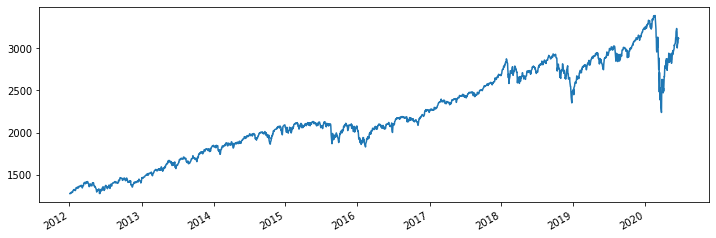

In [5]:
df['adjclose'].plot(subplots=True)

# 2. Prepare data for training

In [8]:
features_considered = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
features = df[df['open'].isna()==False][features_considered]
features = features[features.index > '2012-01-01']
features.tail(2)

,open,high,low,close,adjclose,volume
2020-06-17,3136.129883,3141.159912,3108.030029,3113.489990,3113.489990,4549390000
2020-06-18,3101.639893,3120.000000,3093.510010,3115.340088,3115.340088,4429030000


### 2.1. Standardize data using MinMax Scaler
- MinMax Scaler trained only on training set

In [9]:
data_scaled = features.copy()

TRAIN_SPLIT = int(df.shape[0] * 0.75)

column_scaler = {}
# scale the data (prices) from 0 to 1
for column in data_scaled.columns:
    column_values = data_scaled[column].values.reshape(-1, 1)
    # Fit only on training data
    scaler = MinMaxScaler()
    scaler.fit(column_values[:TRAIN_SPLIT])
    data_scaled[column] = scaler.transform(column_values)
    column_scaler[column] = scaler

data_scaled.tail(3)

,open,high,low,close,adjclose,volume
2020-06-16,1.163998,1.176007,1.141013,1.157832,1.157832,0.721476
2020-06-17,1.167188,1.168297,1.161087,1.150782,1.150782,0.519876
2020-06-18,1.145744,1.155024,1.151970,1.151942,1.151942,0.500918


### 2.2. Split data in batches for training
- Using tf.data module
- **adjclose** as target variable

In [11]:
target_variable = 'adjclose'
past_history = 30
future_target = 7

In [12]:
target_var_index = data_scaled.columns.tolist().index(target_variable)

target = data_scaled[target_variable].values
dataset = data_scaled.values

LAST_SEQUENCE = dataset.shape[0] - 1 - past_history
TEST_SPLIT = LAST_SEQUENCE - 3 * past_history

train_data = prepare_batches(dataset, target,
                             0, TRAIN_SPLIT,
                             past_history, future_target)
val_data = prepare_batches(dataset, target,
                           TRAIN_SPLIT, TEST_SPLIT,
                           past_history, future_target)
test_data = prepare_batches(dataset, target,
                            TEST_SPLIT, LAST_SEQUENCE,
                            past_history, future_target)

# Dataset to predict prices after last datapoint
real_predict_data = prepare_test_batch(dataset, LAST_SEQUENCE, None,  past_history)

- Prepare dates (indexes for plots)

In [13]:
dates = data_scaled[data_scaled.index > HISTORY_START_DATE].index
try: 
    dates = np.array(dates.date, 'str')
except:
    pass

train_dates = prepare_dates(dates, 0, TRAIN_SPLIT, 
                            past_history, future_target)
val_dates = prepare_dates(dates, TRAIN_SPLIT, TEST_SPLIT, 
                          past_history, future_target)
test_dates = prepare_dates(dates, TEST_SPLIT, LAST_SEQUENCE, 
                          past_history, future_target)
real_predict_dates = prepare_dates(dates, LAST_SEQUENCE, None, 
                                   past_history, future_target)
real_predict_dates

<RepeatDataset shapes: ((None, 30, 1), (None, 7)), types: (tf.string, tf.string)>

### 2.3. Example outcome

History date range: 2013-06-24 00:00:00, 2013-08-05 00:00:00
Future date range: 2013-08-06 00:00:00, 2013-08-14 00:00:00


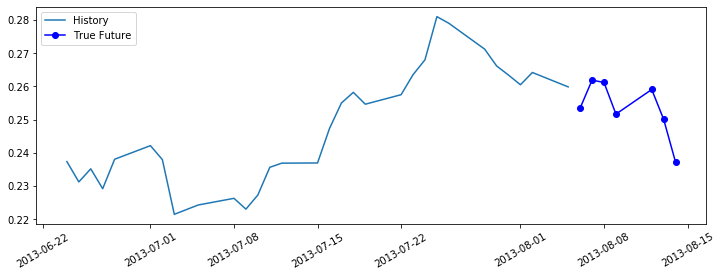

In [16]:
for xy, date in zip(train_data.take(1), train_dates.take(1)):
    x, y = xy
    x_dates, y_dates = date
    history = np.array(x[0])[:, target_var_index]
    true_future = np.array(y[0])
    plot_ts(x_dates[0].numpy(), history,
            y_dates[0].numpy(), true_future)

# 3. Baseline Model

In [18]:
input_shape = (past_history, len(features_considered))
input_shape

(30, 6)

In [19]:
baseline_model = tf.keras.models.Sequential()
baseline_model.add(LSTM(32, return_sequences=True, input_shape=input_shape))
baseline_model.add(LSTM(32, return_sequences=True, activation='relu'))
baseline_model.add(LSTM(32, activation='relu'))
baseline_model.add(Dense(future_target))

baseline_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                       loss='mae')
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            4992      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 21,863
Trainable params: 21,863
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

history = baseline_model.fit(train_data, epochs=50,
                             steps_per_epoch=200,
                             validation_data=val_data,
                             validation_steps=50,
                             callbacks=[early_stopping])

Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 9s 43ms/step - loss: 0.2931 - val_loss: 0.2095
Epoch 2/50
200/200 [==============================] - 7s 35ms/step - loss: 0.0371 - val_loss: 0.0610
Epoch 3/50
200/200 [==============================] - 6s 32ms/step - loss: 0.0257 - val_loss: 0.0537
Epoch 4/50
200/200 [==============================] - 6s 31ms/step - loss: 0.0245 - val_loss: 0.0502
Epoch 5/50
200/200 [==============================] - 7s 33ms/step - loss: 0.0237 - val_loss: 0.0543
Epoch 6/50
200/200 [==============================] - 6s 31ms/step - loss: 0.0233 - val_loss: 0.0452
Epoch 7/50
200/200 [==============================] - 6s 32ms/step - loss: 0.0226 - val_loss: 0.0462
Epoch 8/50
200/200 [==============================] - 7s 33ms/step - loss: 0.0228 - val_loss: 0.0472
Epoch 9/50
200/200 [==============================] - 6s 32ms/step - loss: 0.0222 - val_loss: 0.0417
Epoch 10/50
200/200 [===========================

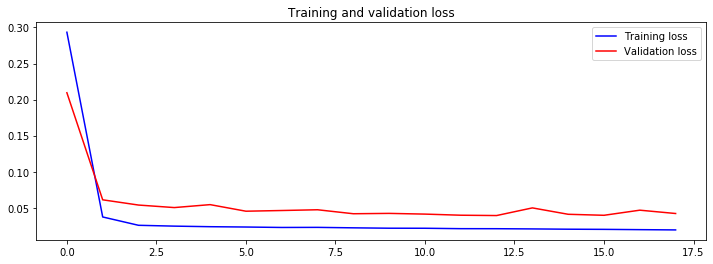

In [21]:
plot_train_history(history, 'Training and validation loss')

### 3.1. See prediction on validation dataset

History date range: 2019-09-25 00:00:00, 2019-11-05 00:00:00
Future date range: 2019-11-06 00:00:00, 2019-11-14 00:00:00


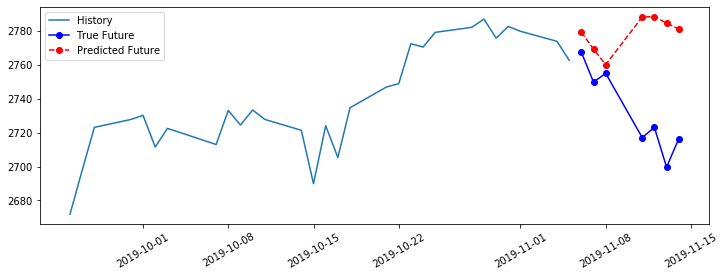

History date range: 2019-09-05 00:00:00, 2019-10-16 00:00:00
Future date range: 2019-10-17 00:00:00, 2019-10-25 00:00:00


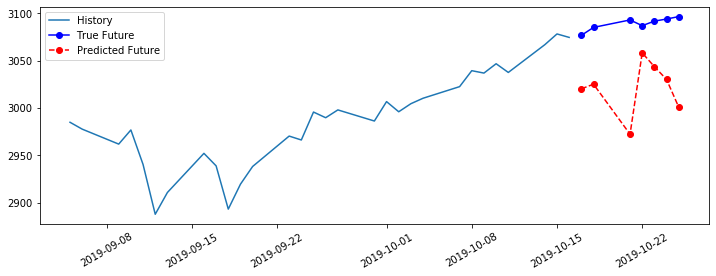

History date range: 2018-06-04 00:00:00, 2018-07-16 00:00:00
Future date range: 2018-07-17 00:00:00, 2018-07-25 00:00:00


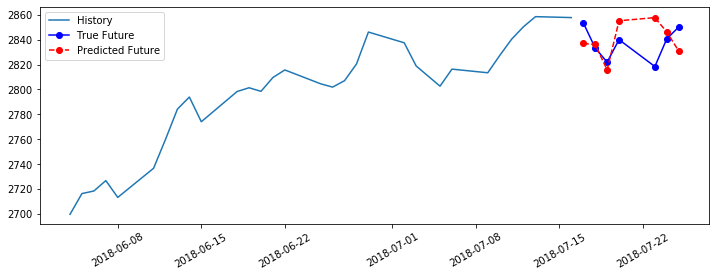

In [22]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    x, y = xy
    x_dates, y_dates = date
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = baseline_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    plot_ts(x_dates[0].numpy(), history,
            y_dates[0].numpy(), true_future,
            prediction_rescaled)

### 3.2. Predict future prices!

History date range: 2020-05-06 00:00:00, 2020-06-17 00:00:00
Future date range: 2020-06-19 00:00:00, 2020-06-29 00:00:00


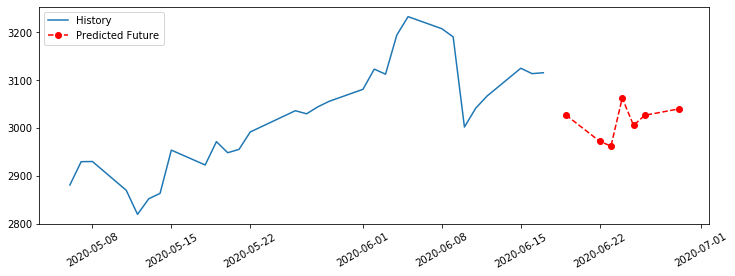

In [23]:
for x, date in zip(real_predict_data.take(1), real_predict_dates.take(1)):
    
    x_dates, y_dates = date
    history = x[0].numpy() [:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    prediction = baseline_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), prediction=prediction_rescaled)

In [25]:
evaluate_model(baseline_model, 'baseline', test_data, 'mae')

,mae,hyperparams
0,0.17589,baseline


# 4. Hyperparameters tuning
- Using Keras-Tuner package

In [34]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=1e-4, s=5)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

def build_model_for_tuning(hp, input_shape=(30, 6), 
                           output_layer_neurons=future_target,
                           output_layer_activation='linear'):
    
    # Setup search space.
    n_hidden = hp.Int('num_layers', 2, 5)
    n_neurons = hp.Choice('units', values=[8, 16, 32, 64])
    lr = hp.Choice('learning_rate', values=[1e-5, 5e-5, 1e-4, 1e-3])
    bidirectional = hp.Boolean('bidir')
    dropout = hp.Choice('dropout', values=[0.2, 0.3, 0.4])
    activation = hp.Choice('activation', values=['tanh', 'relu', 'softmax'])
    
    model = Sequential()
    
    if bidirectional:
        model.add(Bidirectional(LSTM(n_neurons, activation, return_sequences=True),
                                input_shape=input_shape))
        for i in range(n_hidden):
            if i == n_hidden - 1:
                model.add(Bidirectional(LSTM(n_neurons, activation, return_sequences=False)))
            else:
                model.add(Bidirectional(LSTM(n_neurons, activation, return_sequences=True)))
            model.add(Dropout(dropout))
    
    else:
        model.add(LSTM(n_neurons, activation, return_sequences=True,
                       input_shape=input_shape))
        for i in range(n_hidden):
            if i == n_hidden - 1:
                model.add(LSTM(n_neurons, activation, return_sequences=False))
            else:
                model.add(LSTM(n_neurons, activation, return_sequences=True))
            model.add(Dropout(dropout))
    
    # Output layer.
    model.add(Dense(output_layer_neurons, activation=output_layer_activation))

    optimizer = keras.optimizers.Adam(lr)
    model.compile(loss='mae', optimizer=optimizer, callbacks=[early_stopping])

    return model

### 4.1. Define Random Search tuner

In [35]:
tuner = RandomSearch(
    build_model_for_tuning,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner',
    project_name='model_GSPC')

INFO:tensorflow:Reloading Oracle from existing project tuner\model_GSPC\oracle.json


In [36]:
tuner.search_space_summary()

In [37]:
tuner.search(train_data,
             epochs=5,
             steps_per_epoch=200,
             validation_steps=50,
             validation_data=val_data, 
             verbose=1)

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 30:48 - loss: 0.32 - ETA: 15:33 - loss: 0.33 - ETA: 10:27 - loss: 0.34 - ETA: 7:54 - loss: 0.3428 - ETA: 6:22 - loss: 0.355 - ETA: 5:20 - loss: 0.362 - ETA: 4:36 - loss: 0.373 - ETA: 4:03 - loss: 0.382 - ETA: 3:38 - loss: 0.395 - ETA: 3:17 - loss: 0.409 - ETA: 3:00 - loss: 0.414 - ETA: 2:46 - loss: 0.414 - ETA: 2:34 - loss: 0.418 - ETA: 2:24 - loss: 0.421 - ETA: 2:15 - loss: 0.427 - ETA: 2:07 - loss: 0.430 - ETA: 2:00 - loss: 0.429 - ETA: 1:54 - loss: 0.430 - ETA: 1:48 - loss: 0.434 - ETA: 1:43 - loss: 0.436 - ETA: 1:38 - loss: 0.439 - ETA: 1:34 - loss: 0.444 - ETA: 1:30 - loss: 0.448 - ETA: 1:27 - loss: 0.450 - ETA: 1:24 - loss: 0.452 - ETA: 1:21 - loss: 0.447 - ETA: 1:18 - loss: 0.443 - ETA: 1:15 - loss: 0.438 - ETA: 1:13 - loss: 0.435 - ETA: 1:11 - loss: 0.433 - ETA: 1:08 - loss: 0.432 - ETA: 1:06 - loss: 0.432 - ETA: 1:04 - loss: 0.432 - ETA: 1:03 - loss: 0.435 - ETA: 1:01 - loss: 0

200/200 [==============================] - ETA: 18s - loss: 0.23 - ETA: 18s - loss: 0.22 - ETA: 18s - loss: 0.25 - ETA: 18s - loss: 0.26 - ETA: 18s - loss: 0.26 - ETA: 18s - loss: 0.27 - ETA: 18s - loss: 0.28 - ETA: 18s - loss: 0.29 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.31 - ETA: 18s - loss: 0.32 - ETA: 18s - loss: 0.33 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.36 - ETA: 16s - loss: 0.36 - ETA: 15s - loss: 0.36 - ETA: 15s - loss: 0.36

200/200 [==============================] - ETA: 19s - loss: 0.21 - ETA: 18s - loss: 0.21 - ETA: 19s - loss: 0.21 - ETA: 19s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.23 - ETA: 20s - loss: 0.24 - ETA: 19s - loss: 0.25 - ETA: 19s - loss: 0.26 - ETA: 19s - loss: 0.27 - ETA: 19s - loss: 0.28 - ETA: 19s - loss: 0.28 - ETA: 19s - loss: 0.29 - ETA: 18s - loss: 0.29 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.31 - ETA: 18s - loss: 0.31 - ETA: 18s - loss: 0.31 - ETA: 17s - loss: 0.31 - ETA: 17s - loss: 0.31 - ETA: 17s - loss: 0.31 - ETA: 17s - loss: 0.31 - ETA: 17s - loss: 0.31 - ETA: 17s - loss: 0.31 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 16s - loss: 0.31

200/200 [==============================] - ETA: 25s - loss: 0.24 - ETA: 24s - loss: 0.26 - ETA: 24s - loss: 0.26 - ETA: 25s - loss: 0.27 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.29 - ETA: 24s - loss: 0.30 - ETA: 24s - loss: 0.31 - ETA: 24s - loss: 0.32 - ETA: 24s - loss: 0.33 - ETA: 24s - loss: 0.34 - ETA: 23s - loss: 0.35 - ETA: 23s - loss: 0.35 - ETA: 23s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.39 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 21s - loss: 0.37 - ETA: 21s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.38

200/200 [==============================] - ETA: 20s - loss: 0.21 - ETA: 19s - loss: 0.22 - ETA: 19s - loss: 0.23 - ETA: 19s - loss: 0.23 - ETA: 19s - loss: 0.24 - ETA: 19s - loss: 0.24 - ETA: 19s - loss: 0.25 - ETA: 19s - loss: 0.26 - ETA: 19s - loss: 0.26 - ETA: 18s - loss: 0.28 - ETA: 18s - loss: 0.28 - ETA: 18s - loss: 0.29 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.31 - ETA: 18s - loss: 0.31 - ETA: 18s - loss: 0.31 - ETA: 18s - loss: 0.32 - ETA: 18s - loss: 0.32 - ETA: 17s - loss: 0.32 - ETA: 17s - loss: 0.32 - ETA: 17s - loss: 0.32 - ETA: 17s - loss: 0.32 - ETA: 17s - loss: 0.33 - ETA: 17s - loss: 0.33 - ETA: 17s - loss: 0.32 - ETA: 16s - loss: 0.32 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.31 - ETA: 16s - loss: 0.32

200/200 [==============================] - ETA: 31:27 - loss: 0.29 - ETA: 15:52 - loss: 0.31 - ETA: 10:41 - loss: 0.31 - ETA: 8:06 - loss: 0.3307 - ETA: 6:32 - loss: 0.337 - ETA: 5:29 - loss: 0.346 - ETA: 4:44 - loss: 0.353 - ETA: 4:11 - loss: 0.361 - ETA: 3:45 - loss: 0.371 - ETA: 3:24 - loss: 0.385 - ETA: 3:07 - loss: 0.399 - ETA: 2:52 - loss: 0.409 - ETA: 2:40 - loss: 0.411 - ETA: 2:29 - loss: 0.417 - ETA: 2:20 - loss: 0.420 - ETA: 2:12 - loss: 0.423 - ETA: 2:05 - loss: 0.426 - ETA: 1:59 - loss: 0.429 - ETA: 1:53 - loss: 0.433 - ETA: 1:48 - loss: 0.434 - ETA: 1:44 - loss: 0.437 - ETA: 1:40 - loss: 0.440 - ETA: 1:36 - loss: 0.440 - ETA: 1:32 - loss: 0.441 - ETA: 1:29 - loss: 0.443 - ETA: 1:26 - loss: 0.437 - ETA: 1:23 - loss: 0.433 - ETA: 1:20 - loss: 0.430 - ETA: 1:18 - loss: 0.429 - ETA: 1:15 - loss: 0.427 - ETA: 1:13 - loss: 0.426 - ETA: 1:11 - loss: 0.424 - ETA: 1:09 - loss: 0.424 - ETA: 1:08 - loss: 0.424 - ETA: 1:06 - loss: 0.425 - ETA: 1:04 - loss: 0.426 - ETA: 1:03 - loss: 0.

200/200 [==============================] - ETA: 21s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.28 - ETA: 22s - loss: 0.29 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.31 - ETA: 21s - loss: 0.32 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.34 - ETA: 21s - loss: 0.35 - ETA: 21s - loss: 0.34 - ETA: 21s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 21s - loss: 0.35 - ETA: 21s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.35 - ETA: 20s - loss: 0.36

200/200 [==============================] - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.28 - ETA: 21s - loss: 0.28 - ETA: 21s - loss: 0.28 - ETA: 21s - loss: 0.29 - ETA: 21s - loss: 0.29 - ETA: 21s - loss: 0.29 - ETA: 21s - loss: 0.29 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 19s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.30

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 21:54 - loss: 0.30 - ETA: 11:09 - loss: 0.33 - ETA: 7:34 - loss: 0.3345 - ETA: 5:47 - loss: 0.332 - ETA: 4:42 - loss: 0.340 - ETA: 3:59 - loss: 0.349 - ETA: 3:28 - loss: 0.360 - ETA: 3:05 - loss: 0.370 - ETA: 2:46 - loss: 0.383 - ETA: 2:32 - loss: 0.387 - ETA: 2:20 - loss: 0.391 - ETA: 2:11 - loss: 0.400 - ETA: 2:02 - loss: 0.405 - ETA: 1:56 - loss: 0.411 - ETA: 1:50 - loss: 0.419 - ETA: 1:44 - loss: 0.423 - ETA: 1:39 - loss: 0.427 - ETA: 1:35 - loss: 0.430 - ETA: 1:32 - loss: 0.433 - ETA: 1:28 - loss: 0.433 - ETA: 1:25 - loss: 0.436 - ETA: 1:22 - loss: 0.438 - ETA: 1:19 - loss: 0.438 - ETA: 1:17 - loss: 0.437 - ETA: 1:14 - loss: 0.437 - ETA: 1:12 - loss: 0.432 - ETA: 1:10 - loss: 0.427 - ETA: 1:09 - loss: 0.424 - ETA: 1:07 - loss: 0.420 - ETA: 1:05 - loss: 0.418 - ETA: 1:04 - loss: 0.416 - ETA: 1:02 - loss: 0.415 - ETA: 1:01 - loss: 0.416 - ETA: 59s - loss: 0.417 - ETA: 58s - loss: 0.4

200/200 [==============================] - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 27s - loss: 0.04 - ETA: 28s - loss: 0.04 - ETA: 27s - loss: 0.04 - ETA: 27s - loss: 0.04 - ETA: 27s - loss: 0.05 - ETA: 27s - loss: 0.05 - ETA: 27s - loss: 0.05 - ETA: 26s - loss: 0.05 - ETA: 26s - loss: 0.05 - ETA: 26s - loss: 0.05 - ETA: 26s - loss: 0.05 - ETA: 26s - loss: 0.05 - ETA: 26s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 25s - loss: 0.06 - ETA: 25s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05

200/200 [==============================] - ETA: 24s - loss: 0.04 - ETA: 24s - loss: 0.04 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 26s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.04 - ETA: 25s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05

200/200 [==============================] - ETA: 1:12 - loss: 0.056 - ETA: 1:06 - loss: 0.059 - ETA: 1:01 - loss: 0.061 - ETA: 59s - loss: 0.061 - ETA: 57s - loss: 0.06 - ETA: 54s - loss: 0.06 - ETA: 52s - loss: 0.06 - ETA: 51s - loss: 0.06 - ETA: 49s - loss: 0.06 - ETA: 48s - loss: 0.06 - ETA: 48s - loss: 0.06 - ETA: 47s - loss: 0.06 - ETA: 46s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 45s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 44s - loss: 0.07 - ETA: 43s - loss: 0.07 - ETA: 43s - loss: 0.07 - ETA: 43s - loss: 0.07 - ETA: 43s - loss: 0.07 - ETA: 43s - loss: 0.07 - ETA: 42s - loss: 0.07 - ETA: 42s - los

200/200 [==============================] - ETA: 54s - loss: 0.04 - ETA: 52s - loss: 0.04 - ETA: 51s - loss: 0.04 - ETA: 51s - loss: 0.04 - ETA: 50s - loss: 0.04 - ETA: 50s - loss: 0.04 - ETA: 49s - loss: 0.04 - ETA: 49s - loss: 0.04 - ETA: 48s - loss: 0.04 - ETA: 48s - loss: 0.04 - ETA: 48s - loss: 0.05 - ETA: 47s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 38s - loss: 0.05

200/200 [==============================] - ETA: 22:12 - loss: 0.31 - ETA: 11:25 - loss: 0.32 - ETA: 7:50 - loss: 0.3246 - ETA: 6:02 - loss: 0.335 - ETA: 4:57 - loss: 0.345 - ETA: 4:14 - loss: 0.349 - ETA: 3:43 - loss: 0.361 - ETA: 3:19 - loss: 0.373 - ETA: 3:02 - loss: 0.382 - ETA: 2:48 - loss: 0.397 - ETA: 2:37 - loss: 0.406 - ETA: 2:28 - loss: 0.412 - ETA: 2:20 - loss: 0.416 - ETA: 2:13 - loss: 0.420 - ETA: 2:07 - loss: 0.423 - ETA: 2:02 - loss: 0.424 - ETA: 1:57 - loss: 0.427 - ETA: 1:53 - loss: 0.428 - ETA: 1:49 - loss: 0.429 - ETA: 1:45 - loss: 0.430 - ETA: 1:42 - loss: 0.431 - ETA: 1:39 - loss: 0.431 - ETA: 1:36 - loss: 0.432 - ETA: 1:34 - loss: 0.432 - ETA: 1:32 - loss: 0.432 - ETA: 1:30 - loss: 0.427 - ETA: 1:28 - loss: 0.422 - ETA: 1:26 - loss: 0.418 - ETA: 1:24 - loss: 0.415 - ETA: 1:22 - loss: 0.413 - ETA: 1:21 - loss: 0.412 - ETA: 1:19 - loss: 0.411 - ETA: 1:17 - loss: 0.411 - ETA: 1:16 - loss: 0.412 - ETA: 1:14 - loss: 0.412 - ETA: 1:13 - loss: 0.414 - ETA: 1:12 - loss: 0.

200/200 [==============================] - ETA: 45s - loss: 0.03 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 45s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 45s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 44s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 43s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 42s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 41s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 39s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 38s - loss: 0.05

200/200 [==============================] - ETA: 44s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 43s - loss: 0.04 - ETA: 45s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 47s - loss: 0.04 - ETA: 47s - loss: 0.04 - ETA: 47s - loss: 0.04 - ETA: 48s - loss: 0.04 - ETA: 48s - loss: 0.04 - ETA: 48s - loss: 0.04 - ETA: 48s - loss: 0.04 - ETA: 48s - loss: 0.04 - ETA: 47s - loss: 0.04 - ETA: 47s - loss: 0.04 - ETA: 47s - loss: 0.04 - ETA: 47s - loss: 0.04 - ETA: 47s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.05 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 46s - loss: 0.04 - ETA: 45s - loss: 0.04 - ETA: 45s - loss: 0.04 - ETA: 45s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 44s - loss: 0.04 - ETA: 43s - loss: 0.04 - ETA: 43s - loss: 0.04 - ETA: 43s - loss: 0.04 - ETA: 42s - loss: 0.04 - ETA: 42s - loss: 0.04

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 35:54 - loss: 0.31 - ETA: 18:05 - loss: 0.33 - ETA: 12:08 - loss: 0.33 - ETA: 9:10 - loss: 0.3443 - ETA: 7:23 - loss: 0.352 - ETA: 6:11 - loss: 0.354 - ETA: 5:20 - loss: 0.367 - ETA: 4:41 - loss: 0.379 - ETA: 4:11 - loss: 0.395 - ETA: 3:47 - loss: 0.400 - ETA: 3:28 - loss: 0.408 - ETA: 3:12 - loss: 0.411 - ETA: 2:58 - loss: 0.413 - ETA: 2:46 - loss: 0.417 - ETA: 2:36 - loss: 0.419 - ETA: 2:27 - loss: 0.422 - ETA: 2:19 - loss: 0.422 - ETA: 2:12 - loss: 0.426 - ETA: 2:06 - loss: 0.430 - ETA: 2:01 - loss: 0.433 - ETA: 1:56 - loss: 0.435 - ETA: 1:51 - loss: 0.435 - ETA: 1:47 - loss: 0.437 - ETA: 1:43 - loss: 0.438 - ETA: 1:40 - loss: 0.439 - ETA: 1:37 - loss: 0.434 - ETA: 1:34 - loss: 0.428 - ETA: 1:31 - loss: 0.424 - ETA: 1:28 - loss: 0.421 - ETA: 1:25 - loss: 0.419 - ETA: 1:23 - loss: 0.417 - ETA: 1:21 - loss: 0.417 - ETA: 1:19 - loss: 0.417 - ETA: 1:16 - loss: 0.421 - ETA: 1:15 - loss: 0

200/200 [==============================] - ETA: 26s - loss: 0.11 - ETA: 27s - loss: 0.12 - ETA: 28s - loss: 0.11 - ETA: 28s - loss: 0.11 - ETA: 28s - loss: 0.11 - ETA: 28s - loss: 0.12 - ETA: 28s - loss: 0.12 - ETA: 28s - loss: 0.12 - ETA: 28s - loss: 0.13 - ETA: 28s - loss: 0.13 - ETA: 28s - loss: 0.13 - ETA: 28s - loss: 0.13 - ETA: 28s - loss: 0.13 - ETA: 28s - loss: 0.13 - ETA: 27s - loss: 0.13 - ETA: 27s - loss: 0.13 - ETA: 27s - loss: 0.13 - ETA: 27s - loss: 0.13 - ETA: 27s - loss: 0.14 - ETA: 27s - loss: 0.14 - ETA: 27s - loss: 0.14 - ETA: 26s - loss: 0.14 - ETA: 26s - loss: 0.14 - ETA: 26s - loss: 0.14 - ETA: 26s - loss: 0.14 - ETA: 26s - loss: 0.14 - ETA: 26s - loss: 0.14 - ETA: 26s - loss: 0.14 - ETA: 25s - loss: 0.13 - ETA: 25s - loss: 0.13 - ETA: 25s - loss: 0.13 - ETA: 25s - loss: 0.13 - ETA: 25s - loss: 0.13 - ETA: 25s - loss: 0.13 - ETA: 25s - loss: 0.13 - ETA: 25s - loss: 0.13 - ETA: 24s - loss: 0.13 - ETA: 24s - loss: 0.13 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14

200/200 [==============================] - ETA: 24s - loss: 0.07 - ETA: 24s - loss: 0.06 - ETA: 24s - loss: 0.07 - ETA: 25s - loss: 0.07 - ETA: 26s - loss: 0.08 - ETA: 26s - loss: 0.08 - ETA: 25s - loss: 0.08 - ETA: 25s - loss: 0.08 - ETA: 25s - loss: 0.09 - ETA: 25s - loss: 0.09 - ETA: 25s - loss: 0.09 - ETA: 25s - loss: 0.09 - ETA: 24s - loss: 0.10 - ETA: 24s - loss: 0.10 - ETA: 24s - loss: 0.10 - ETA: 24s - loss: 0.10 - ETA: 24s - loss: 0.10 - ETA: 23s - loss: 0.10 - ETA: 23s - loss: 0.10 - ETA: 23s - loss: 0.10 - ETA: 23s - loss: 0.10 - ETA: 23s - loss: 0.10 - ETA: 23s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10

200/200 [==============================] - ETA: 24s - loss: 0.26 - ETA: 23s - loss: 0.24 - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.26 - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.26 - ETA: 23s - loss: 0.28 - ETA: 23s - loss: 0.28 - ETA: 23s - loss: 0.29 - ETA: 23s - loss: 0.29 - ETA: 23s - loss: 0.30 - ETA: 23s - loss: 0.31 - ETA: 23s - loss: 0.31 - ETA: 23s - loss: 0.31 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 22s - loss: 0.31 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 21s - loss: 0.32 - ETA: 21s - loss: 0.32 - ETA: 21s - loss: 0.32 - ETA: 21s - loss: 0.31 - ETA: 21s - loss: 0.31 - ETA: 21s - loss: 0.31 - ETA: 21s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31

200/200 [==============================] - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.12 - ETA: 24s - loss: 0.11 - ETA: 24s - loss: 0.11 - ETA: 24s - loss: 0.11 - ETA: 23s - loss: 0.11 - ETA: 24s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 23s - loss: 0.12 - ETA: 24s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.15 - ETA: 21s - loss: 0.15 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 21s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14 - ETA: 20s - loss: 0.14

200/200 [==============================] - ETA: 35:07 - loss: 0.34 - ETA: 17:43 - loss: 0.34 - ETA: 11:55 - loss: 0.33 - ETA: 9:01 - loss: 0.3440 - ETA: 7:16 - loss: 0.356 - ETA: 6:06 - loss: 0.364 - ETA: 5:16 - loss: 0.367 - ETA: 4:39 - loss: 0.372 - ETA: 4:10 - loss: 0.378 - ETA: 3:46 - loss: 0.380 - ETA: 3:27 - loss: 0.392 - ETA: 3:11 - loss: 0.401 - ETA: 2:57 - loss: 0.408 - ETA: 2:46 - loss: 0.413 - ETA: 2:36 - loss: 0.418 - ETA: 2:28 - loss: 0.422 - ETA: 2:20 - loss: 0.425 - ETA: 2:14 - loss: 0.428 - ETA: 2:08 - loss: 0.432 - ETA: 2:02 - loss: 0.436 - ETA: 1:57 - loss: 0.438 - ETA: 1:53 - loss: 0.439 - ETA: 1:49 - loss: 0.442 - ETA: 1:45 - loss: 0.441 - ETA: 1:42 - loss: 0.440 - ETA: 1:38 - loss: 0.434 - ETA: 1:35 - loss: 0.429 - ETA: 1:32 - loss: 0.425 - ETA: 1:30 - loss: 0.423 - ETA: 1:27 - loss: 0.423 - ETA: 1:25 - loss: 0.422 - ETA: 1:22 - loss: 0.421 - ETA: 1:20 - loss: 0.421 - ETA: 1:18 - loss: 0.421 - ETA: 1:16 - loss: 0.423 - ETA: 1:14 - loss: 0.425 - ETA: 1:13 - loss: 0.

200/200 [==============================] - ETA: 31s - loss: 0.13 - ETA: 30s - loss: 0.13 - ETA: 31s - loss: 0.12 - ETA: 31s - loss: 0.13 - ETA: 31s - loss: 0.13 - ETA: 31s - loss: 0.13 - ETA: 31s - loss: 0.13 - ETA: 30s - loss: 0.13 - ETA: 30s - loss: 0.14 - ETA: 30s - loss: 0.14 - ETA: 30s - loss: 0.14 - ETA: 30s - loss: 0.14 - ETA: 30s - loss: 0.14 - ETA: 29s - loss: 0.15 - ETA: 29s - loss: 0.15 - ETA: 29s - loss: 0.15 - ETA: 29s - loss: 0.15 - ETA: 29s - loss: 0.15 - ETA: 28s - loss: 0.15 - ETA: 28s - loss: 0.15 - ETA: 28s - loss: 0.16 - ETA: 28s - loss: 0.16 - ETA: 28s - loss: 0.16 - ETA: 28s - loss: 0.16 - ETA: 28s - loss: 0.16 - ETA: 28s - loss: 0.15 - ETA: 27s - loss: 0.15 - ETA: 27s - loss: 0.15 - ETA: 27s - loss: 0.15 - ETA: 27s - loss: 0.15 - ETA: 27s - loss: 0.15 - ETA: 27s - loss: 0.15 - ETA: 26s - loss: 0.15 - ETA: 26s - loss: 0.15 - ETA: 26s - loss: 0.15 - ETA: 26s - loss: 0.15 - ETA: 26s - loss: 0.15 - ETA: 26s - loss: 0.15 - ETA: 26s - loss: 0.15 - ETA: 25s - loss: 0.15

200/200 [==============================] - ETA: 51s - loss: 0.08 - ETA: 46s - loss: 0.09 - ETA: 43s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 35s - loss: 0.09 - ETA: 34s - loss: 0.09 - ETA: 34s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 32s - loss: 0.10 - ETA: 32s - loss: 0.10 - ETA: 31s - loss: 0.10 - ETA: 31s - loss: 0.10 - ETA: 30s - loss: 0.10 - ETA: 30s - loss: 0.10 - ETA: 30s - loss: 0.10 - ETA: 30s - loss: 0.11 - ETA: 30s - loss: 0.11 - ETA: 30s - loss: 0.11 - ETA: 29s - loss: 0.11 - ETA: 29s - loss: 0.11 - ETA: 29s - loss: 0.11 - ETA: 29s - loss: 0.11 - ETA: 28s - loss: 0.10 - ETA: 28s - loss: 0.10 - ETA: 28s - loss: 0.10 - ETA: 28s - loss: 0.10 - ETA: 28s - loss: 0.10 - ETA: 27s - loss: 0.10 - ETA: 27s - loss: 0.10 - ETA: 27s - loss: 0.10 - ETA: 27s - loss: 0.10 - ETA: 27s - loss: 0.10 - ETA: 27s - loss: 0.10 - ETA: 26s - loss: 0.10 - ETA: 26s - loss: 0.10 - ETA: 26s - loss: 0.10

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 15:10 - loss: 0.30 - ETA: 7:39 - loss: 0.2994 - ETA: 5:08 - loss: 0.298 - ETA: 3:52 - loss: 0.299 - ETA: 2:36 - loss: 0.307 - ETA: 1:57 - loss: 0.330 - ETA: 1:34 - loss: 0.354 - ETA: 1:19 - loss: 0.367 - ETA: 1:08 - loss: 0.378 - ETA: 59s - loss: 0.385 - ETA: 53s - loss: 0.39 - ETA: 48s - loss: 0.39 - ETA: 44s - loss: 0.39 - ETA: 42s - loss: 0.39 - ETA: 39s - loss: 0.40 - ETA: 36s - loss: 0.39 - ETA: 34s - loss: 0.38 - ETA: 31s - loss: 0.38 - ETA: 30s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 25s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 20s - loss: 0.39 - ETA: 19s - loss: 0.40 - ETA: 18s - loss: 0.39 - ETA: 18s - loss: 0.39 - ETA: 17s - loss: 0.39 - ETA: 16s - loss: 0.39 - ETA: 16s - loss: 0.39 - ETA: 15s - loss: 0.39 - ETA: 15s - loss: 0.39 - ETA: 14s - loss: 0.39 - ETA: 14s - loss: 0.3

200/200 [==============================] - ETA: 10s - loss: 0.19 - ETA: 10s - loss: 0.22 - ETA: 11s - loss: 0.23 - ETA: 10s - loss: 0.25 - ETA: 10s - loss: 0.25 - ETA: 10s - loss: 0.25 - ETA: 10s - loss: 0.26 - ETA: 10s - loss: 0.27 - ETA: 10s - loss: 0.28 - ETA: 10s - loss: 0.29 - ETA: 10s - loss: 0.30 - ETA: 10s - loss: 0.31 - ETA: 9s - loss: 0.3252 - ETA: 9s - loss: 0.332 - ETA: 9s - loss: 0.339 - ETA: 9s - loss: 0.345 - ETA: 8s - loss: 0.348 - ETA: 8s - loss: 0.353 - ETA: 8s - loss: 0.343 - ETA: 8s - loss: 0.337 - ETA: 8s - loss: 0.334 - ETA: 8s - loss: 0.337 - ETA: 8s - loss: 0.339 - ETA: 7s - loss: 0.342 - ETA: 7s - loss: 0.346 - ETA: 7s - loss: 0.348 - ETA: 7s - loss: 0.348 - ETA: 7s - loss: 0.350 - ETA: 7s - loss: 0.351 - ETA: 7s - loss: 0.352 - ETA: 7s - loss: 0.350 - ETA: 6s - loss: 0.346 - ETA: 6s - loss: 0.344 - ETA: 6s - loss: 0.343 - ETA: 6s - loss: 0.343 - ETA: 6s - loss: 0.344 - ETA: 6s - loss: 0.345 - ETA: 6s - loss: 0.346 - ETA: 6s - loss: 0.347 - ETA: 6s - loss: 0.34

Epoch 1/5
200/200 [==============================] - ETA: 14:15 - loss: 0.24 - ETA: 7:14 - loss: 0.2474 - ETA: 4:53 - loss: 0.251 - ETA: 3:43 - loss: 0.258 - ETA: 2:59 - loss: 0.270 - ETA: 2:31 - loss: 0.275 - ETA: 2:10 - loss: 0.290 - ETA: 1:54 - loss: 0.302 - ETA: 1:42 - loss: 0.313 - ETA: 1:32 - loss: 0.316 - ETA: 1:24 - loss: 0.321 - ETA: 1:18 - loss: 0.329 - ETA: 1:12 - loss: 0.333 - ETA: 1:07 - loss: 0.339 - ETA: 1:03 - loss: 0.345 - ETA: 59s - loss: 0.347 - ETA: 53s - loss: 0.35 - ETA: 48s - loss: 0.35 - ETA: 44s - loss: 0.35 - ETA: 40s - loss: 0.36 - ETA: 37s - loss: 0.35 - ETA: 35s - loss: 0.35 - ETA: 32s - loss: 0.34 - ETA: 30s - loss: 0.34 - ETA: 29s - loss: 0.34 - ETA: 27s - loss: 0.34 - ETA: 26s - loss: 0.35 - ETA: 24s - loss: 0.35 - ETA: 23s - loss: 0.35 - ETA: 22s - loss: 0.35 - ETA: 21s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 19s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 16:23 - loss: 0.33 - ETA: 8:18 - loss: 0.3324 - ETA: 5:36 - loss: 0.326 - ETA: 4:14 - loss: 0.319 - ETA: 3:25 - loss: 0.331 - ETA: 2:52 - loss: 0.346 - ETA: 2:29 - loss: 0.359 - ETA: 2:11 - loss: 0.370 - ETA: 1:58 - loss: 0.384 - ETA: 1:47 - loss: 0.394 - ETA: 1:38 - loss: 0.404 - ETA: 1:31 - loss: 0.411 - ETA: 1:24 - loss: 0.418 - ETA: 1:19 - loss: 0.421 - ETA: 1:14 - loss: 0.424 - ETA: 1:10 - loss: 0.427 - ETA: 1:07 - loss: 0.432 - ETA: 1:04 - loss: 0.435 - ETA: 1:01 - loss: 0.437 - ETA: 58s - loss: 0.440 - ETA: 56s - loss: 0.44 - ETA: 53s - loss: 0.44 - ETA: 51s - loss: 0.44 - ETA: 49s - loss: 0.44 - ETA: 48s - loss: 0.44 - ETA: 46s - loss: 0.43 - ETA: 44s - loss: 0.43 - ETA: 43s - loss: 0.42 - ETA: 42s - loss: 0.42 - ETA: 40s - loss: 0.42 - ETA: 39s - loss: 0.42 - ETA: 38s - loss: 0.42 - ETA: 37s - loss: 0.42 - ETA: 36s - loss: 0.42 - ETA: 35s - loss: 0.42 - ETA: 34s - loss: 0.42 - 

200/200 [==============================] - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.08 - ETA: 19s - loss: 0.08 - ETA: 19s - loss: 0.08 - ETA: 19s - loss: 0.08 - ETA: 19s - loss: 0.08 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09

200/200 [==============================] - ETA: 22s - loss: 0.06 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.05 - ETA: 22s - loss: 0.06 - ETA: 22s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 21s - loss: 0.06 - ETA: 21s - loss: 0.07 - ETA: 21s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 20s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07

200/200 [==============================] - ETA: 36s - loss: 0.18 - ETA: 34s - loss: 0.19 - ETA: 35s - loss: 0.19 - ETA: 35s - loss: 0.20 - ETA: 35s - loss: 0.20 - ETA: 34s - loss: 0.20 - ETA: 34s - loss: 0.20 - ETA: 34s - loss: 0.21 - ETA: 33s - loss: 0.22 - ETA: 33s - loss: 0.22 - ETA: 32s - loss: 0.23 - ETA: 32s - loss: 0.23 - ETA: 32s - loss: 0.24 - ETA: 32s - loss: 0.24 - ETA: 32s - loss: 0.24 - ETA: 32s - loss: 0.24 - ETA: 32s - loss: 0.25 - ETA: 32s - loss: 0.25 - ETA: 31s - loss: 0.25 - ETA: 31s - loss: 0.25 - ETA: 31s - loss: 0.25 - ETA: 31s - loss: 0.25 - ETA: 31s - loss: 0.25 - ETA: 31s - loss: 0.25 - ETA: 30s - loss: 0.25 - ETA: 30s - loss: 0.25 - ETA: 30s - loss: 0.24 - ETA: 29s - loss: 0.24 - ETA: 29s - loss: 0.24 - ETA: 29s - loss: 0.24 - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 26s - loss: 0.23

200/200 [==============================] - ETA: 33s - loss: 0.07 - ETA: 36s - loss: 0.06 - ETA: 36s - loss: 0.06 - ETA: 37s - loss: 0.06 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 28s - loss: 0.08 - ETA: 28s - loss: 0.08

200/200 [==============================] - ETA: 16:02 - loss: 0.33 - ETA: 8:15 - loss: 0.3142 - ETA: 5:38 - loss: 0.330 - ETA: 4:19 - loss: 0.342 - ETA: 3:31 - loss: 0.352 - ETA: 3:00 - loss: 0.363 - ETA: 2:37 - loss: 0.377 - ETA: 2:20 - loss: 0.384 - ETA: 2:07 - loss: 0.390 - ETA: 1:56 - loss: 0.397 - ETA: 1:47 - loss: 0.406 - ETA: 1:40 - loss: 0.412 - ETA: 1:34 - loss: 0.418 - ETA: 1:28 - loss: 0.423 - ETA: 1:24 - loss: 0.430 - ETA: 1:20 - loss: 0.432 - ETA: 1:16 - loss: 0.437 - ETA: 1:13 - loss: 0.440 - ETA: 1:10 - loss: 0.443 - ETA: 1:07 - loss: 0.445 - ETA: 1:05 - loss: 0.445 - ETA: 1:03 - loss: 0.447 - ETA: 1:01 - loss: 0.449 - ETA: 59s - loss: 0.450 - ETA: 57s - loss: 0.44 - ETA: 56s - loss: 0.44 - ETA: 54s - loss: 0.43 - ETA: 53s - loss: 0.43 - ETA: 52s - loss: 0.43 - ETA: 50s - loss: 0.43 - ETA: 49s - loss: 0.43 - ETA: 48s - loss: 0.43 - ETA: 47s - loss: 0.43 - ETA: 46s - loss: 0.43 - ETA: 45s - loss: 0.43 - ETA: 44s - loss: 0.43 - ETA: 44s - loss: 0.43 - ETA: 43s - loss: 0.43

200/200 [==============================] - ETA: 35s - loss: 0.08 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 33s - loss: 0.12 - ETA: 33s - loss: 0.12 - ETA: 33s - loss: 0.12 - ETA: 32s - loss: 0.12 - ETA: 32s - loss: 0.12 - ETA: 32s - loss: 0.12 - ETA: 32s - loss: 0.12 - ETA: 32s - loss: 0.12 - ETA: 32s - loss: 0.12 - ETA: 31s - loss: 0.12 - ETA: 31s - loss: 0.12 - ETA: 31s - loss: 0.13 - ETA: 31s - loss: 0.12 - ETA: 30s - loss: 0.12 - ETA: 30s - loss: 0.12 - ETA: 30s - loss: 0.12 - ETA: 30s - loss: 0.12 - ETA: 30s - loss: 0.12 - ETA: 30s - loss: 0.12 - ETA: 30s - loss: 0.12 - ETA: 30s - loss: 0.12 - ETA: 29s - loss: 0.12 - ETA: 29s - loss: 0.12 - ETA: 29s - loss: 0.12 - ETA: 29s - loss: 0.12 - ETA: 29s - loss: 0.12 - ETA: 29s - loss: 0.12

200/200 [==============================] - ETA: 37s - loss: 0.06 - ETA: 36s - loss: 0.06 - ETA: 36s - loss: 0.06 - ETA: 36s - loss: 0.06 - ETA: 37s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.09 - ETA: 32s - loss: 0.09 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 30s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 29s - loss: 0.08 - ETA: 28s - loss: 0.08

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 29:06 - loss: 0.27 - ETA: 14:46 - loss: 0.27 - ETA: 9:59 - loss: 0.2868 - ETA: 7:35 - loss: 0.298 - ETA: 6:08 - loss: 0.301 - ETA: 5:09 - loss: 0.305 - ETA: 4:28 - loss: 0.317 - ETA: 3:57 - loss: 0.327 - ETA: 3:33 - loss: 0.341 - ETA: 3:14 - loss: 0.350 - ETA: 2:58 - loss: 0.359 - ETA: 2:44 - loss: 0.366 - ETA: 2:33 - loss: 0.371 - ETA: 2:23 - loss: 0.375 - ETA: 2:15 - loss: 0.380 - ETA: 2:08 - loss: 0.385 - ETA: 2:01 - loss: 0.390 - ETA: 1:55 - loss: 0.395 - ETA: 1:50 - loss: 0.398 - ETA: 1:45 - loss: 0.401 - ETA: 1:41 - loss: 0.403 - ETA: 1:37 - loss: 0.404 - ETA: 1:34 - loss: 0.406 - ETA: 1:30 - loss: 0.406 - ETA: 1:27 - loss: 0.405 - ETA: 1:24 - loss: 0.400 - ETA: 1:21 - loss: 0.396 - ETA: 1:19 - loss: 0.394 - ETA: 1:17 - loss: 0.391 - ETA: 1:14 - loss: 0.388 - ETA: 1:12 - loss: 0.388 - ETA: 1:10 - loss: 0.386 - ETA: 1:09 - loss: 0.388 - ETA: 1:07 - loss: 0.390 - ETA: 1:05 - loss: 0

200/200 [==============================] - ETA: 32s - loss: 0.23 - ETA: 30s - loss: 0.23 - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.24 - ETA: 27s - loss: 0.25 - ETA: 27s - loss: 0.25 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.27 - ETA: 26s - loss: 0.28 - ETA: 26s - loss: 0.29 - ETA: 26s - loss: 0.30 - ETA: 26s - loss: 0.30 - ETA: 26s - loss: 0.31 - ETA: 25s - loss: 0.31 - ETA: 25s - loss: 0.32 - ETA: 25s - loss: 0.32 - ETA: 25s - loss: 0.32 - ETA: 25s - loss: 0.32 - ETA: 25s - loss: 0.32 - ETA: 25s - loss: 0.33 - ETA: 24s - loss: 0.33 - ETA: 24s - loss: 0.33 - ETA: 24s - loss: 0.33 - ETA: 24s - loss: 0.33 - ETA: 24s - loss: 0.33 - ETA: 24s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32

200/200 [==============================] - ETA: 27s - loss: 0.18 - ETA: 27s - loss: 0.19 - ETA: 27s - loss: 0.20 - ETA: 27s - loss: 0.20 - ETA: 26s - loss: 0.20 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.22 - ETA: 26s - loss: 0.23 - ETA: 26s - loss: 0.24 - ETA: 25s - loss: 0.25 - ETA: 25s - loss: 0.25 - ETA: 25s - loss: 0.26 - ETA: 25s - loss: 0.26 - ETA: 25s - loss: 0.26 - ETA: 25s - loss: 0.26 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.28 - ETA: 24s - loss: 0.28 - ETA: 23s - loss: 0.28 - ETA: 23s - loss: 0.28 - ETA: 23s - loss: 0.28 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.26 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 21s - loss: 0.27 - ETA: 21s - loss: 0.27

200/200 [==============================] - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.29 - ETA: 27s - loss: 0.30 - ETA: 27s - loss: 0.30 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.32 - ETA: 27s - loss: 0.34 - ETA: 27s - loss: 0.34 - ETA: 27s - loss: 0.35 - ETA: 27s - loss: 0.36 - ETA: 26s - loss: 0.36 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 26s - loss: 0.39 - ETA: 26s - loss: 0.39 - ETA: 25s - loss: 0.40 - ETA: 25s - loss: 0.40 - ETA: 25s - loss: 0.40 - ETA: 25s - loss: 0.40 - ETA: 25s - loss: 0.40 - ETA: 25s - loss: 0.40 - ETA: 24s - loss: 0.40 - ETA: 24s - loss: 0.40 - ETA: 24s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 24s - loss: 0.38 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.40

200/200 [==============================] - ETA: 28s - loss: 0.23 - ETA: 28s - loss: 0.24 - ETA: 27s - loss: 0.24 - ETA: 27s - loss: 0.24 - ETA: 27s - loss: 0.25 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.27 - ETA: 27s - loss: 0.28 - ETA: 27s - loss: 0.29 - ETA: 27s - loss: 0.30 - ETA: 27s - loss: 0.30 - ETA: 26s - loss: 0.31 - ETA: 26s - loss: 0.31 - ETA: 26s - loss: 0.32 - ETA: 26s - loss: 0.32 - ETA: 26s - loss: 0.33 - ETA: 26s - loss: 0.33 - ETA: 26s - loss: 0.33 - ETA: 25s - loss: 0.33 - ETA: 25s - loss: 0.34 - ETA: 25s - loss: 0.34 - ETA: 25s - loss: 0.34 - ETA: 25s - loss: 0.34 - ETA: 25s - loss: 0.34 - ETA: 24s - loss: 0.34 - ETA: 24s - loss: 0.33 - ETA: 24s - loss: 0.33 - ETA: 24s - loss: 0.32 - ETA: 24s - loss: 0.32 - ETA: 24s - loss: 0.32 - ETA: 24s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.32 - ETA: 22s - loss: 0.32 - ETA: 22s - loss: 0.32

200/200 [==============================] - ETA: 29:47 - loss: 0.32 - ETA: 15:02 - loss: 0.34 - ETA: 10:06 - loss: 0.35 - ETA: 7:38 - loss: 0.3616 - ETA: 6:09 - loss: 0.360 - ETA: 5:09 - loss: 0.366 - ETA: 4:27 - loss: 0.372 - ETA: 3:55 - loss: 0.387 - ETA: 3:30 - loss: 0.396 - ETA: 3:10 - loss: 0.406 - ETA: 2:53 - loss: 0.415 - ETA: 2:40 - loss: 0.420 - ETA: 2:28 - loss: 0.424 - ETA: 2:18 - loss: 0.429 - ETA: 2:10 - loss: 0.431 - ETA: 2:02 - loss: 0.436 - ETA: 1:56 - loss: 0.437 - ETA: 1:50 - loss: 0.442 - ETA: 1:44 - loss: 0.442 - ETA: 1:40 - loss: 0.444 - ETA: 1:35 - loss: 0.446 - ETA: 1:31 - loss: 0.448 - ETA: 1:28 - loss: 0.449 - ETA: 1:24 - loss: 0.453 - ETA: 1:21 - loss: 0.452 - ETA: 1:18 - loss: 0.447 - ETA: 1:16 - loss: 0.443 - ETA: 1:13 - loss: 0.441 - ETA: 1:11 - loss: 0.440 - ETA: 1:09 - loss: 0.437 - ETA: 1:07 - loss: 0.435 - ETA: 1:05 - loss: 0.433 - ETA: 1:03 - loss: 0.433 - ETA: 1:01 - loss: 0.434 - ETA: 1:00 - loss: 0.436 - ETA: 58s - loss: 0.435 - ETA: 57s - loss: 0.43

200/200 [==============================] - ETA: 25s - loss: 0.26 - ETA: 27s - loss: 0.26 - ETA: 27s - loss: 0.27 - ETA: 27s - loss: 0.28 - ETA: 27s - loss: 0.29 - ETA: 26s - loss: 0.29 - ETA: 26s - loss: 0.30 - ETA: 25s - loss: 0.31 - ETA: 25s - loss: 0.31 - ETA: 25s - loss: 0.32 - ETA: 25s - loss: 0.33 - ETA: 24s - loss: 0.34 - ETA: 24s - loss: 0.35 - ETA: 24s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.35 - ETA: 21s - loss: 0.35 - ETA: 21s - loss: 0.35 - ETA: 21s - loss: 0.35 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36

200/200 [==============================] - ETA: 23s - loss: 0.20 - ETA: 22s - loss: 0.20 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.26 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 21s - loss: 0.28 - ETA: 21s - loss: 0.28 - ETA: 21s - loss: 0.29 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.31 - ETA: 21s - loss: 0.31 - ETA: 21s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 20s - loss: 0.31 - ETA: 19s - loss: 0.31 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 18s - loss: 0.30

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 22:12 - loss: 0.31 - ETA: 11:14 - loss: 0.33 - ETA: 7:35 - loss: 0.3270 - ETA: 5:44 - loss: 0.329 - ETA: 4:38 - loss: 0.341 - ETA: 3:54 - loss: 0.356 - ETA: 3:22 - loss: 0.367 - ETA: 2:59 - loss: 0.376 - ETA: 2:40 - loss: 0.383 - ETA: 2:25 - loss: 0.396 - ETA: 2:13 - loss: 0.405 - ETA: 2:03 - loss: 0.418 - ETA: 1:55 - loss: 0.428 - ETA: 1:48 - loss: 0.433 - ETA: 1:42 - loss: 0.438 - ETA: 1:37 - loss: 0.442 - ETA: 1:32 - loss: 0.443 - ETA: 1:28 - loss: 0.444 - ETA: 1:24 - loss: 0.446 - ETA: 1:21 - loss: 0.446 - ETA: 1:18 - loss: 0.448 - ETA: 1:15 - loss: 0.449 - ETA: 1:12 - loss: 0.452 - ETA: 1:10 - loss: 0.453 - ETA: 1:08 - loss: 0.453 - ETA: 1:06 - loss: 0.448 - ETA: 1:04 - loss: 0.444 - ETA: 1:02 - loss: 0.441 - ETA: 1:00 - loss: 0.439 - ETA: 58s - loss: 0.437 - ETA: 57s - loss: 0.43 - ETA: 55s - loss: 0.43 - ETA: 54s - loss: 0.43 - ETA: 53s - loss: 0.43 - ETA: 52s - loss: 0.43 - ETA:

200/200 [==============================] - ETA: 38s - loss: 0.33 - ETA: 37s - loss: 0.33 - ETA: 34s - loss: 0.33 - ETA: 32s - loss: 0.34 - ETA: 31s - loss: 0.34 - ETA: 30s - loss: 0.34 - ETA: 29s - loss: 0.35 - ETA: 29s - loss: 0.36 - ETA: 29s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 28s - loss: 0.39 - ETA: 27s - loss: 0.40 - ETA: 27s - loss: 0.41 - ETA: 27s - loss: 0.41 - ETA: 27s - loss: 0.42 - ETA: 26s - loss: 0.42 - ETA: 26s - loss: 0.43 - ETA: 26s - loss: 0.43 - ETA: 25s - loss: 0.43 - ETA: 25s - loss: 0.43 - ETA: 25s - loss: 0.43 - ETA: 25s - loss: 0.43 - ETA: 25s - loss: 0.44 - ETA: 25s - loss: 0.44 - ETA: 24s - loss: 0.44 - ETA: 24s - loss: 0.44 - ETA: 24s - loss: 0.43 - ETA: 24s - loss: 0.43 - ETA: 24s - loss: 0.43 - ETA: 23s - loss: 0.43 - ETA: 23s - loss: 0.43 - ETA: 23s - loss: 0.42 - ETA: 23s - loss: 0.42 - ETA: 23s - loss: 0.42 - ETA: 23s - loss: 0.42 - ETA: 23s - loss: 0.43 - ETA: 22s - loss: 0.43 - ETA: 22s - loss: 0.43 - ETA: 22s - loss: 0.43 - ETA: 22s - loss: 0.43

200/200 [==============================] - ETA: 42s - loss: 0.27 - ETA: 41s - loss: 0.30 - ETA: 38s - loss: 0.31 - ETA: 37s - loss: 0.32 - ETA: 35s - loss: 0.33 - ETA: 34s - loss: 0.35 - ETA: 33s - loss: 0.36 - ETA: 32s - loss: 0.37 - ETA: 31s - loss: 0.37 - ETA: 30s - loss: 0.37 - ETA: 30s - loss: 0.38 - ETA: 29s - loss: 0.38 - ETA: 29s - loss: 0.39 - ETA: 29s - loss: 0.39 - ETA: 28s - loss: 0.40 - ETA: 28s - loss: 0.40 - ETA: 28s - loss: 0.41 - ETA: 27s - loss: 0.41 - ETA: 27s - loss: 0.42 - ETA: 27s - loss: 0.42 - ETA: 27s - loss: 0.42 - ETA: 26s - loss: 0.43 - ETA: 26s - loss: 0.43 - ETA: 26s - loss: 0.43 - ETA: 26s - loss: 0.43 - ETA: 25s - loss: 0.43 - ETA: 25s - loss: 0.43 - ETA: 25s - loss: 0.42 - ETA: 25s - loss: 0.42 - ETA: 25s - loss: 0.42 - ETA: 24s - loss: 0.41 - ETA: 24s - loss: 0.42 - ETA: 24s - loss: 0.42 - ETA: 24s - loss: 0.42 - ETA: 24s - loss: 0.42 - ETA: 23s - loss: 0.42 - ETA: 23s - loss: 0.42 - ETA: 23s - loss: 0.42 - ETA: 23s - loss: 0.42 - ETA: 23s - loss: 0.42

200/200 [==============================] - ETA: 32s - loss: 0.31 - ETA: 32s - loss: 0.32 - ETA: 32s - loss: 0.32 - ETA: 31s - loss: 0.32 - ETA: 31s - loss: 0.34 - ETA: 30s - loss: 0.35 - ETA: 30s - loss: 0.35 - ETA: 30s - loss: 0.36 - ETA: 29s - loss: 0.37 - ETA: 29s - loss: 0.38 - ETA: 29s - loss: 0.38 - ETA: 29s - loss: 0.39 - ETA: 29s - loss: 0.39 - ETA: 29s - loss: 0.40 - ETA: 29s - loss: 0.40 - ETA: 29s - loss: 0.40 - ETA: 29s - loss: 0.41 - ETA: 29s - loss: 0.41 - ETA: 29s - loss: 0.41 - ETA: 28s - loss: 0.41 - ETA: 28s - loss: 0.42 - ETA: 28s - loss: 0.42 - ETA: 28s - loss: 0.42 - ETA: 28s - loss: 0.42 - ETA: 27s - loss: 0.43 - ETA: 27s - loss: 0.42 - ETA: 27s - loss: 0.42 - ETA: 27s - loss: 0.41 - ETA: 26s - loss: 0.41 - ETA: 26s - loss: 0.41 - ETA: 26s - loss: 0.41 - ETA: 26s - loss: 0.41 - ETA: 26s - loss: 0.41 - ETA: 25s - loss: 0.41 - ETA: 25s - loss: 0.41 - ETA: 25s - loss: 0.41 - ETA: 25s - loss: 0.41 - ETA: 25s - loss: 0.42 - ETA: 25s - loss: 0.42 - ETA: 25s - loss: 0.42

200/200 [==============================] - ETA: 30s - loss: 0.31 - ETA: 33s - loss: 0.31 - ETA: 37s - loss: 0.30 - ETA: 41s - loss: 0.31 - ETA: 42s - loss: 0.31 - ETA: 42s - loss: 0.32 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.34 - ETA: 43s - loss: 0.35 - ETA: 44s - loss: 0.36 - ETA: 44s - loss: 0.37 - ETA: 43s - loss: 0.37 - ETA: 42s - loss: 0.38 - ETA: 41s - loss: 0.38 - ETA: 40s - loss: 0.39 - ETA: 40s - loss: 0.39 - ETA: 39s - loss: 0.40 - ETA: 39s - loss: 0.40 - ETA: 38s - loss: 0.40 - ETA: 38s - loss: 0.40 - ETA: 38s - loss: 0.41 - ETA: 38s - loss: 0.41 - ETA: 39s - loss: 0.41 - ETA: 39s - loss: 0.42 - ETA: 39s - loss: 0.42 - ETA: 39s - loss: 0.41 - ETA: 39s - loss: 0.41 - ETA: 40s - loss: 0.41 - ETA: 40s - loss: 0.40 - ETA: 39s - loss: 0.40 - ETA: 38s - loss: 0.40 - ETA: 38s - loss: 0.40 - ETA: 37s - loss: 0.40 - ETA: 37s - loss: 0.40 - ETA: 36s - loss: 0.40 - ETA: 35s - loss: 0.40 - ETA: 35s - loss: 0.41 - ETA: 34s - loss: 0.41 - ETA: 34s - loss: 0.41 - ETA: 33s - loss: 0.41

200/200 [==============================] - ETA: 22:12 - loss: 0.31 - ETA: 11:19 - loss: 0.31 - ETA: 7:41 - loss: 0.3240 - ETA: 5:52 - loss: 0.323 - ETA: 4:46 - loss: 0.332 - ETA: 4:02 - loss: 0.342 - ETA: 3:31 - loss: 0.352 - ETA: 3:07 - loss: 0.362 - ETA: 2:49 - loss: 0.367 - ETA: 2:34 - loss: 0.372 - ETA: 2:22 - loss: 0.380 - ETA: 2:12 - loss: 0.386 - ETA: 2:03 - loss: 0.393 - ETA: 1:55 - loss: 0.394 - ETA: 1:49 - loss: 0.400 - ETA: 1:43 - loss: 0.408 - ETA: 1:38 - loss: 0.410 - ETA: 1:34 - loss: 0.413 - ETA: 1:30 - loss: 0.417 - ETA: 1:27 - loss: 0.419 - ETA: 1:24 - loss: 0.423 - ETA: 1:21 - loss: 0.424 - ETA: 1:18 - loss: 0.427 - ETA: 1:16 - loss: 0.430 - ETA: 1:13 - loss: 0.432 - ETA: 1:11 - loss: 0.426 - ETA: 1:10 - loss: 0.423 - ETA: 1:08 - loss: 0.419 - ETA: 1:06 - loss: 0.417 - ETA: 1:05 - loss: 0.416 - ETA: 1:03 - loss: 0.414 - ETA: 1:02 - loss: 0.413 - ETA: 1:01 - loss: 0.412 - ETA: 59s - loss: 0.414 - ETA: 58s - loss: 0.41 - ETA: 57s - loss: 0.41 - ETA: 56s - loss: 0.41 - E

200/200 [==============================] - ETA: 57s - loss: 0.26 - ETA: 50s - loss: 0.30 - ETA: 46s - loss: 0.31 - ETA: 48s - loss: 0.31 - ETA: 49s - loss: 0.32 - ETA: 50s - loss: 0.33 - ETA: 51s - loss: 0.33 - ETA: 51s - loss: 0.35 - ETA: 52s - loss: 0.35 - ETA: 52s - loss: 0.36 - ETA: 52s - loss: 0.37 - ETA: 52s - loss: 0.38 - ETA: 51s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 49s - loss: 0.40 - ETA: 48s - loss: 0.40 - ETA: 47s - loss: 0.40 - ETA: 46s - loss: 0.41 - ETA: 45s - loss: 0.41 - ETA: 45s - loss: 0.41 - ETA: 45s - loss: 0.41 - ETA: 45s - loss: 0.41 - ETA: 45s - loss: 0.42 - ETA: 44s - loss: 0.42 - ETA: 44s - loss: 0.42 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 44s - loss: 0.41 - ETA: 43s - loss: 0.40 - ETA: 43s - loss: 0.40 - ETA: 43s - loss: 0.40 - ETA: 43s - loss: 0.40 - ETA: 43s - loss: 0.40 - ETA: 42s - loss: 0.41 - ETA: 42s - loss: 0.41 - ETA: 41s - loss: 0.41 - ETA: 41s - loss: 0.41 - ETA: 40s - loss: 0.41 - ETA: 40s - loss: 0.41

200/200 [==============================] - ETA: 34s - loss: 0.28 - ETA: 32s - loss: 0.28 - ETA: 31s - loss: 0.30 - ETA: 31s - loss: 0.30 - ETA: 31s - loss: 0.31 - ETA: 30s - loss: 0.32 - ETA: 31s - loss: 0.33 - ETA: 31s - loss: 0.34 - ETA: 32s - loss: 0.35 - ETA: 33s - loss: 0.36 - ETA: 33s - loss: 0.37 - ETA: 33s - loss: 0.38 - ETA: 33s - loss: 0.38 - ETA: 33s - loss: 0.39 - ETA: 33s - loss: 0.39 - ETA: 33s - loss: 0.40 - ETA: 33s - loss: 0.40 - ETA: 32s - loss: 0.40 - ETA: 32s - loss: 0.40 - ETA: 32s - loss: 0.41 - ETA: 32s - loss: 0.40 - ETA: 32s - loss: 0.41 - ETA: 32s - loss: 0.41 - ETA: 32s - loss: 0.41 - ETA: 31s - loss: 0.41 - ETA: 31s - loss: 0.41 - ETA: 31s - loss: 0.40 - ETA: 31s - loss: 0.40 - ETA: 31s - loss: 0.40 - ETA: 30s - loss: 0.40 - ETA: 30s - loss: 0.40 - ETA: 30s - loss: 0.40 - ETA: 30s - loss: 0.40 - ETA: 30s - loss: 0.40 - ETA: 30s - loss: 0.40 - ETA: 29s - loss: 0.40 - ETA: 29s - loss: 0.40 - ETA: 29s - loss: 0.40 - ETA: 29s - loss: 0.40 - ETA: 29s - loss: 0.41

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 9:49 - loss: 0.321 - ETA: 5:05 - loss: 0.330 - ETA: 3:30 - loss: 0.326 - ETA: 2:43 - loss: 0.326 - ETA: 2:14 - loss: 0.333 - ETA: 1:54 - loss: 0.340 - ETA: 1:39 - loss: 0.349 - ETA: 1:28 - loss: 0.360 - ETA: 1:20 - loss: 0.373 - ETA: 1:13 - loss: 0.376 - ETA: 1:07 - loss: 0.387 - ETA: 1:03 - loss: 0.399 - ETA: 59s - loss: 0.403 - ETA: 55s - loss: 0.40 - ETA: 52s - loss: 0.41 - ETA: 50s - loss: 0.41 - ETA: 47s - loss: 0.41 - ETA: 45s - loss: 0.42 - ETA: 43s - loss: 0.42 - ETA: 42s - loss: 0.42 - ETA: 40s - loss: 0.42 - ETA: 39s - loss: 0.42 - ETA: 37s - loss: 0.43 - ETA: 36s - loss: 0.43 - ETA: 35s - loss: 0.43 - ETA: 34s - loss: 0.43 - ETA: 33s - loss: 0.42 - ETA: 32s - loss: 0.42 - ETA: 31s - loss: 0.42 - ETA: 31s - loss: 0.41 - ETA: 30s - loss: 0.41 - ETA: 29s - loss: 0.41 - ETA: 28s - loss: 0.41 - ETA: 28s - loss: 0.42 - ETA: 27s - loss: 0.42 - ETA: 27s - loss: 0.42 - ETA: 26s - loss

200/200 [==============================] - ETA: 15s - loss: 0.32 - ETA: 15s - loss: 0.32 - ETA: 15s - loss: 0.31 - ETA: 14s - loss: 0.32 - ETA: 14s - loss: 0.32 - ETA: 14s - loss: 0.33 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.36 - ETA: 13s - loss: 0.37 - ETA: 13s - loss: 0.38 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 12s - loss: 0.40 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.42 - ETA: 12s - loss: 0.42 - ETA: 12s - loss: 0.42 - ETA: 12s - loss: 0.43 - ETA: 11s - loss: 0.42 - ETA: 11s - loss: 0.42 - ETA: 11s - loss: 0.41 - ETA: 11s - loss: 0.41 - ETA: 11s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41

200/200 [==============================] - ETA: 19s - loss: 0.28 - ETA: 16s - loss: 0.29 - ETA: 16s - loss: 0.30 - ETA: 15s - loss: 0.31 - ETA: 15s - loss: 0.31 - ETA: 14s - loss: 0.32 - ETA: 14s - loss: 0.33 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.37 - ETA: 14s - loss: 0.37 - ETA: 13s - loss: 0.38 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41 - ETA: 14s - loss: 0.41 - ETA: 14s - loss: 0.41 - ETA: 14s - loss: 0.42 - ETA: 14s - loss: 0.42 - ETA: 14s - loss: 0.42 - ETA: 14s - loss: 0.42 - ETA: 14s - loss: 0.41 - ETA: 14s - loss: 0.41 - ETA: 14s - loss: 0.41 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41

200/200 [==============================] - ETA: 23s - loss: 0.29 - ETA: 23s - loss: 0.30 - ETA: 23s - loss: 0.31 - ETA: 23s - loss: 0.32 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.34 - ETA: 23s - loss: 0.34 - ETA: 22s - loss: 0.36 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.40 - ETA: 22s - loss: 0.40 - ETA: 22s - loss: 0.40 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.41 - ETA: 22s - loss: 0.42 - ETA: 22s - loss: 0.42 - ETA: 21s - loss: 0.42 - ETA: 21s - loss: 0.42 - ETA: 21s - loss: 0.42 - ETA: 21s - loss: 0.43 - ETA: 21s - loss: 0.43 - ETA: 21s - loss: 0.43 - ETA: 21s - loss: 0.43 - ETA: 20s - loss: 0.43 - ETA: 20s - loss: 0.42 - ETA: 20s - loss: 0.42 - ETA: 20s - loss: 0.42 - ETA: 20s - loss: 0.42 - ETA: 20s - loss: 0.42 - ETA: 20s - loss: 0.41 - ETA: 20s - loss: 0.41 - ETA: 20s - loss: 0.42 - ETA: 19s - loss: 0.42 - ETA: 19s - loss: 0.42 - ETA: 19s - loss: 0.42 - ETA: 19s - loss: 0.42 - ETA: 19s - loss: 0.42 - ETA: 19s - loss: 0.43

200/200 [==============================] - ETA: 18s - loss: 0.31 - ETA: 16s - loss: 0.32 - ETA: 15s - loss: 0.32 - ETA: 15s - loss: 0.32 - ETA: 14s - loss: 0.33 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.35 - ETA: 13s - loss: 0.36 - ETA: 13s - loss: 0.37 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.41 - ETA: 13s - loss: 0.42 - ETA: 13s - loss: 0.42 - ETA: 12s - loss: 0.42 - ETA: 12s - loss: 0.42 - ETA: 12s - loss: 0.42 - ETA: 12s - loss: 0.43 - ETA: 12s - loss: 0.42 - ETA: 12s - loss: 0.42 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.42

200/200 [==============================] - ETA: 10:14 - loss: 0.29 - ETA: 5:13 - loss: 0.3118 - ETA: 3:32 - loss: 0.319 - ETA: 2:42 - loss: 0.318 - ETA: 2:11 - loss: 0.325 - ETA: 1:51 - loss: 0.334 - ETA: 1:36 - loss: 0.343 - ETA: 1:26 - loss: 0.350 - ETA: 1:17 - loss: 0.365 - ETA: 1:11 - loss: 0.372 - ETA: 1:05 - loss: 0.380 - ETA: 1:01 - loss: 0.393 - ETA: 57s - loss: 0.400 - ETA: 53s - loss: 0.40 - ETA: 50s - loss: 0.40 - ETA: 48s - loss: 0.41 - ETA: 45s - loss: 0.41 - ETA: 43s - loss: 0.41 - ETA: 41s - loss: 0.41 - ETA: 40s - loss: 0.42 - ETA: 38s - loss: 0.42 - ETA: 37s - loss: 0.42 - ETA: 35s - loss: 0.42 - ETA: 34s - loss: 0.42 - ETA: 33s - loss: 0.42 - ETA: 32s - loss: 0.41 - ETA: 31s - loss: 0.41 - ETA: 30s - loss: 0.41 - ETA: 29s - loss: 0.40 - ETA: 28s - loss: 0.40 - ETA: 28s - loss: 0.40 - ETA: 27s - loss: 0.40 - ETA: 26s - loss: 0.40 - ETA: 26s - loss: 0.40 - ETA: 25s - loss: 0.40 - ETA: 25s - loss: 0.41 - ETA: 24s - loss: 0.41 - ETA: 23s - loss: 0.41 - ETA: 23s - loss: 0.

200/200 [==============================] - ETA: 16s - loss: 0.32 - ETA: 15s - loss: 0.32 - ETA: 14s - loss: 0.32 - ETA: 14s - loss: 0.33 - ETA: 14s - loss: 0.33 - ETA: 14s - loss: 0.32 - ETA: 14s - loss: 0.34 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.36 - ETA: 15s - loss: 0.36 - ETA: 15s - loss: 0.37 - ETA: 15s - loss: 0.38 - ETA: 15s - loss: 0.39 - ETA: 15s - loss: 0.39 - ETA: 15s - loss: 0.39 - ETA: 15s - loss: 0.40 - ETA: 15s - loss: 0.40 - ETA: 15s - loss: 0.40 - ETA: 15s - loss: 0.40 - ETA: 15s - loss: 0.40 - ETA: 15s - loss: 0.40 - ETA: 16s - loss: 0.41 - ETA: 16s - loss: 0.41 - ETA: 16s - loss: 0.41 - ETA: 16s - loss: 0.42 - ETA: 16s - loss: 0.41 - ETA: 16s - loss: 0.41 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40 - ETA: 16s - loss: 0.40

200/200 [==============================] - ETA: 16s - loss: 0.27 - ETA: 14s - loss: 0.27 - ETA: 14s - loss: 0.28 - ETA: 13s - loss: 0.29 - ETA: 13s - loss: 0.29 - ETA: 13s - loss: 0.30 - ETA: 13s - loss: 0.31 - ETA: 13s - loss: 0.32 - ETA: 13s - loss: 0.33 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.36 - ETA: 13s - loss: 0.37 - ETA: 13s - loss: 0.37 - ETA: 12s - loss: 0.37 - ETA: 12s - loss: 0.38 - ETA: 12s - loss: 0.38 - ETA: 12s - loss: 0.38 - ETA: 12s - loss: 0.39 - ETA: 12s - loss: 0.39 - ETA: 12s - loss: 0.40 - ETA: 12s - loss: 0.40 - ETA: 12s - loss: 0.40 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.41 - ETA: 12s - loss: 0.40 - ETA: 12s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.40 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.39 - ETA: 13s - loss: 0.40 - ETA: 14s - loss: 0.40 - ETA: 14s - loss: 0.40 - ETA: 14s - loss: 0.40 - ETA: 14s - loss: 0.40 - ETA: 14s - loss: 0.40

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 36:17 - loss: 0.31 - ETA: 18:59 - loss: 0.31 - ETA: 13:12 - loss: 0.30 - ETA: 10:19 - loss: 0.30 - ETA: 8:39 - loss: 0.3214 - ETA: 7:33 - loss: 0.330 - ETA: 6:44 - loss: 0.350 - ETA: 6:05 - loss: 0.365 - ETA: 5:35 - loss: 0.376 - ETA: 5:10 - loss: 0.384 - ETA: 4:50 - loss: 0.389 - ETA: 4:33 - loss: 0.397 - ETA: 4:19 - loss: 0.402 - ETA: 4:09 - loss: 0.409 - ETA: 4:00 - loss: 0.413 - ETA: 3:51 - loss: 0.414 - ETA: 3:44 - loss: 0.421 - ETA: 3:37 - loss: 0.423 - ETA: 3:31 - loss: 0.425 - ETA: 3:26 - loss: 0.427 - ETA: 3:20 - loss: 0.431 - ETA: 3:16 - loss: 0.433 - ETA: 3:12 - loss: 0.436 - ETA: 3:08 - loss: 0.436 - ETA: 3:03 - loss: 0.437 - ETA: 2:59 - loss: 0.431 - ETA: 2:56 - loss: 0.426 - ETA: 2:53 - loss: 0.424 - ETA: 2:50 - loss: 0.422 - ETA: 2:47 - loss: 0.418 - ETA: 2:44 - loss: 0.416 - ETA: 2:42 - loss: 0.415 - ETA: 2:39 - loss: 0.417 - ETA: 2:37 - loss: 0.420 - ETA: 2:35 - loss: 0

200/200 [==============================] - ETA: 2:20 - loss: 0.314 - ETA: 2:19 - loss: 0.318 - ETA: 2:16 - loss: 0.332 - ETA: 2:14 - loss: 0.334 - ETA: 2:12 - loss: 0.349 - ETA: 2:09 - loss: 0.356 - ETA: 2:09 - loss: 0.361 - ETA: 2:09 - loss: 0.366 - ETA: 2:08 - loss: 0.374 - ETA: 2:08 - loss: 0.379 - ETA: 2:07 - loss: 0.386 - ETA: 2:07 - loss: 0.392 - ETA: 2:05 - loss: 0.394 - ETA: 2:04 - loss: 0.399 - ETA: 2:05 - loss: 0.405 - ETA: 2:04 - loss: 0.408 - ETA: 2:03 - loss: 0.409 - ETA: 2:03 - loss: 0.412 - ETA: 2:02 - loss: 0.414 - ETA: 2:01 - loss: 0.417 - ETA: 2:00 - loss: 0.420 - ETA: 1:59 - loss: 0.423 - ETA: 1:59 - loss: 0.426 - ETA: 1:58 - loss: 0.428 - ETA: 1:56 - loss: 0.428 - ETA: 1:56 - loss: 0.424 - ETA: 1:55 - loss: 0.420 - ETA: 1:54 - loss: 0.415 - ETA: 1:54 - loss: 0.413 - ETA: 1:53 - loss: 0.409 - ETA: 1:52 - loss: 0.409 - ETA: 1:52 - loss: 0.408 - ETA: 1:51 - loss: 0.409 - ETA: 1:51 - loss: 0.410 - ETA: 1:50 - loss: 0.413 - ETA: 1:49 - loss: 0.415 - ETA: 1:49 - loss: 0.4

200/200 [==============================] - ETA: 1:49 - loss: 0.296 - ETA: 1:50 - loss: 0.304 - ETA: 1:50 - loss: 0.311 - ETA: 1:53 - loss: 0.320 - ETA: 2:02 - loss: 0.329 - ETA: 2:05 - loss: 0.334 - ETA: 2:05 - loss: 0.339 - ETA: 2:06 - loss: 0.354 - ETA: 2:05 - loss: 0.363 - ETA: 2:04 - loss: 0.373 - ETA: 2:04 - loss: 0.384 - ETA: 2:04 - loss: 0.388 - ETA: 2:03 - loss: 0.396 - ETA: 2:03 - loss: 0.400 - ETA: 2:03 - loss: 0.405 - ETA: 2:02 - loss: 0.408 - ETA: 2:02 - loss: 0.409 - ETA: 2:01 - loss: 0.410 - ETA: 2:01 - loss: 0.410 - ETA: 2:01 - loss: 0.409 - ETA: 2:01 - loss: 0.412 - ETA: 2:00 - loss: 0.415 - ETA: 1:59 - loss: 0.417 - ETA: 1:59 - loss: 0.419 - ETA: 1:57 - loss: 0.422 - ETA: 1:56 - loss: 0.416 - ETA: 1:55 - loss: 0.412 - ETA: 1:55 - loss: 0.409 - ETA: 1:54 - loss: 0.406 - ETA: 1:53 - loss: 0.404 - ETA: 1:53 - loss: 0.404 - ETA: 1:52 - loss: 0.404 - ETA: 1:51 - loss: 0.405 - ETA: 1:51 - loss: 0.408 - ETA: 1:50 - loss: 0.408 - ETA: 1:50 - loss: 0.408 - ETA: 1:49 - loss: 0.4

200/200 [==============================] - ETA: 2:08 - loss: 0.339 - ETA: 2:28 - loss: 0.316 - ETA: 2:26 - loss: 0.333 - ETA: 2:20 - loss: 0.334 - ETA: 2:15 - loss: 0.346 - ETA: 2:11 - loss: 0.356 - ETA: 2:08 - loss: 0.364 - ETA: 2:06 - loss: 0.372 - ETA: 2:05 - loss: 0.381 - ETA: 2:07 - loss: 0.389 - ETA: 2:07 - loss: 0.400 - ETA: 2:05 - loss: 0.408 - ETA: 2:04 - loss: 0.410 - ETA: 2:02 - loss: 0.414 - ETA: 2:01 - loss: 0.419 - ETA: 1:59 - loss: 0.421 - ETA: 1:58 - loss: 0.422 - ETA: 1:58 - loss: 0.426 - ETA: 1:58 - loss: 0.428 - ETA: 1:58 - loss: 0.432 - ETA: 1:58 - loss: 0.436 - ETA: 1:58 - loss: 0.438 - ETA: 1:57 - loss: 0.441 - ETA: 1:56 - loss: 0.441 - ETA: 1:54 - loss: 0.441 - ETA: 1:53 - loss: 0.434 - ETA: 1:54 - loss: 0.430 - ETA: 1:53 - loss: 0.426 - ETA: 1:53 - loss: 0.424 - ETA: 1:53 - loss: 0.423 - ETA: 1:52 - loss: 0.422 - ETA: 1:52 - loss: 0.421 - ETA: 1:51 - loss: 0.422 - ETA: 1:51 - loss: 0.423 - ETA: 1:51 - loss: 0.424 - ETA: 1:50 - loss: 0.426 - ETA: 1:49 - loss: 0.4

200/200 [==============================] - ETA: 2:00 - loss: 0.295 - ETA: 2:02 - loss: 0.304 - ETA: 2:11 - loss: 0.305 - ETA: 2:16 - loss: 0.312 - ETA: 2:18 - loss: 0.329 - ETA: 2:17 - loss: 0.340 - ETA: 2:14 - loss: 0.343 - ETA: 2:11 - loss: 0.355 - ETA: 2:09 - loss: 0.369 - ETA: 2:09 - loss: 0.384 - ETA: 2:10 - loss: 0.386 - ETA: 2:10 - loss: 0.390 - ETA: 2:09 - loss: 0.395 - ETA: 2:08 - loss: 0.405 - ETA: 2:06 - loss: 0.409 - ETA: 2:04 - loss: 0.412 - ETA: 2:04 - loss: 0.416 - ETA: 2:04 - loss: 0.421 - ETA: 2:05 - loss: 0.425 - ETA: 2:05 - loss: 0.427 - ETA: 2:05 - loss: 0.429 - ETA: 2:03 - loss: 0.429 - ETA: 2:02 - loss: 0.431 - ETA: 2:00 - loss: 0.432 - ETA: 1:58 - loss: 0.433 - ETA: 1:58 - loss: 0.427 - ETA: 1:58 - loss: 0.422 - ETA: 1:57 - loss: 0.420 - ETA: 1:57 - loss: 0.417 - ETA: 1:56 - loss: 0.414 - ETA: 1:55 - loss: 0.414 - ETA: 1:55 - loss: 0.413 - ETA: 1:55 - loss: 0.415 - ETA: 1:54 - loss: 0.416 - ETA: 1:54 - loss: 0.418 - ETA: 1:53 - loss: 0.419 - ETA: 1:53 - loss: 0.4

200/200 [==============================] - ETA: 36:39 - loss: 0.33 - ETA: 19:13 - loss: 0.32 - ETA: 13:25 - loss: 0.33 - ETA: 10:31 - loss: 0.34 - ETA: 8:45 - loss: 0.3502 - ETA: 7:38 - loss: 0.362 - ETA: 6:52 - loss: 0.375 - ETA: 6:16 - loss: 0.379 - ETA: 5:49 - loss: 0.386 - ETA: 5:26 - loss: 0.403 - ETA: 5:08 - loss: 0.411 - ETA: 4:52 - loss: 0.418 - ETA: 4:38 - loss: 0.421 - ETA: 4:28 - loss: 0.426 - ETA: 4:17 - loss: 0.431 - ETA: 4:07 - loss: 0.434 - ETA: 3:57 - loss: 0.436 - ETA: 3:49 - loss: 0.436 - ETA: 3:42 - loss: 0.439 - ETA: 3:35 - loss: 0.443 - ETA: 3:29 - loss: 0.445 - ETA: 3:25 - loss: 0.448 - ETA: 3:20 - loss: 0.449 - ETA: 3:15 - loss: 0.451 - ETA: 3:09 - loss: 0.450 - ETA: 3:05 - loss: 0.445 - ETA: 3:01 - loss: 0.440 - ETA: 2:57 - loss: 0.437 - ETA: 2:54 - loss: 0.435 - ETA: 2:51 - loss: 0.433 - ETA: 2:50 - loss: 0.432 - ETA: 2:47 - loss: 0.431 - ETA: 2:44 - loss: 0.432 - ETA: 2:41 - loss: 0.435 - ETA: 2:38 - loss: 0.436 - ETA: 2:36 - loss: 0.437 - ETA: 2:33 - loss: 0.

200/200 [==============================] - ETA: 2:16 - loss: 0.316 - ETA: 2:07 - loss: 0.312 - ETA: 2:03 - loss: 0.323 - ETA: 2:00 - loss: 0.329 - ETA: 1:59 - loss: 0.339 - ETA: 1:58 - loss: 0.352 - ETA: 1:58 - loss: 0.355 - ETA: 2:00 - loss: 0.370 - ETA: 2:03 - loss: 0.380 - ETA: 2:04 - loss: 0.389 - ETA: 2:05 - loss: 0.395 - ETA: 2:05 - loss: 0.402 - ETA: 2:03 - loss: 0.409 - ETA: 2:02 - loss: 0.412 - ETA: 2:01 - loss: 0.415 - ETA: 2:01 - loss: 0.419 - ETA: 2:01 - loss: 0.421 - ETA: 2:01 - loss: 0.427 - ETA: 2:01 - loss: 0.428 - ETA: 2:01 - loss: 0.434 - ETA: 2:01 - loss: 0.437 - ETA: 2:00 - loss: 0.439 - ETA: 2:00 - loss: 0.441 - ETA: 2:00 - loss: 0.442 - ETA: 1:58 - loss: 0.444 - ETA: 1:58 - loss: 0.440 - ETA: 1:57 - loss: 0.437 - ETA: 1:56 - loss: 0.433 - ETA: 1:55 - loss: 0.428 - ETA: 1:54 - loss: 0.425 - ETA: 1:53 - loss: 0.425 - ETA: 1:53 - loss: 0.425 - ETA: 1:53 - loss: 0.427 - ETA: 1:52 - loss: 0.427 - ETA: 1:52 - loss: 0.428 - ETA: 1:51 - loss: 0.429 - ETA: 1:51 - loss: 0.4

200/200 [==============================] - ETA: 2:26 - loss: 0.311 - ETA: 2:24 - loss: 0.315 - ETA: 2:23 - loss: 0.311 - ETA: 2:23 - loss: 0.312 - ETA: 2:22 - loss: 0.318 - ETA: 2:21 - loss: 0.339 - ETA: 2:21 - loss: 0.342 - ETA: 2:20 - loss: 0.353 - ETA: 2:19 - loss: 0.361 - ETA: 2:18 - loss: 0.370 - ETA: 2:18 - loss: 0.377 - ETA: 2:17 - loss: 0.387 - ETA: 2:16 - loss: 0.394 - ETA: 2:16 - loss: 0.398 - ETA: 2:16 - loss: 0.400 - ETA: 2:15 - loss: 0.405 - ETA: 2:14 - loss: 0.414 - ETA: 2:13 - loss: 0.419 - ETA: 2:13 - loss: 0.420 - ETA: 2:12 - loss: 0.421 - ETA: 2:11 - loss: 0.423 - ETA: 2:11 - loss: 0.426 - ETA: 2:10 - loss: 0.430 - ETA: 2:09 - loss: 0.434 - ETA: 2:07 - loss: 0.436 - ETA: 2:06 - loss: 0.430 - ETA: 2:05 - loss: 0.426 - ETA: 2:05 - loss: 0.423 - ETA: 2:04 - loss: 0.421 - ETA: 2:03 - loss: 0.418 - ETA: 2:03 - loss: 0.418 - ETA: 2:02 - loss: 0.418 - ETA: 2:01 - loss: 0.420 - ETA: 2:00 - loss: 0.422 - ETA: 2:00 - loss: 0.424 - ETA: 1:59 - loss: 0.423 - ETA: 1:58 - loss: 0.4

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 37:06 - loss: 0.32 - ETA: 18:56 - loss: 0.32 - ETA: 12:54 - loss: 0.33 - ETA: 9:52 - loss: 0.3434 - ETA: 8:03 - loss: 0.349 - ETA: 6:51 - loss: 0.353 - ETA: 5:58 - loss: 0.351 - ETA: 5:19 - loss: 0.365 - ETA: 4:48 - loss: 0.374 - ETA: 4:23 - loss: 0.382 - ETA: 4:03 - loss: 0.389 - ETA: 3:45 - loss: 0.392 - ETA: 3:31 - loss: 0.395 - ETA: 3:18 - loss: 0.396 - ETA: 3:08 - loss: 0.401 - ETA: 2:58 - loss: 0.398 - ETA: 2:50 - loss: 0.401 - ETA: 2:42 - loss: 0.401 - ETA: 2:36 - loss: 0.401 - ETA: 2:30 - loss: 0.403 - ETA: 2:24 - loss: 0.400 - ETA: 2:19 - loss: 0.401 - ETA: 2:14 - loss: 0.399 - ETA: 2:10 - loss: 0.398 - ETA: 2:06 - loss: 0.396 - ETA: 2:02 - loss: 0.390 - ETA: 1:59 - loss: 0.385 - ETA: 1:56 - loss: 0.378 - ETA: 1:53 - loss: 0.374 - ETA: 1:50 - loss: 0.370 - ETA: 1:47 - loss: 0.367 - ETA: 1:45 - loss: 0.364 - ETA: 1:43 - loss: 0.362 - ETA: 1:41 - loss: 0.361 - ETA: 1:39 - loss: 0

200/200 [==============================] - ETA: 1:08 - loss: 0.083 - ETA: 1:01 - loss: 0.094 - ETA: 1:00 - loss: 0.091 - ETA: 59s - loss: 0.096 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 55s - loss: 0.12 - ETA: 55s - loss: 0.12 - ETA: 54s - loss: 0.12 - ETA: 54s - loss: 0.12 - ETA: 53s - loss: 0.12 - ETA: 53s - loss: 0.12 - ETA: 53s - loss: 0.12 - ETA: 52s - loss: 0.12 - ETA: 51s - loss: 0.12 - ETA: 51s - loss: 0.12 - ETA: 51s - loss: 0.12 - ETA: 50s - loss: 0.12 - ETA: 50s - loss: 0.12 - ETA: 50s - loss: 0.12 - ETA: 49s - loss: 0.12 - ETA: 49s - loss: 0.12 - ETA: 49s - loss: 0.12 - ETA: 48s - loss: 0.12 - ETA: 48s - loss: 0.12 - ETA: 48s - loss: 0.12 - ETA: 48s - loss: 0.12 - ETA: 47s - loss: 0.12 - ETA: 47s - loss: 0.12 - ETA: 47s - los

200/200 [==============================] - ETA: 57s - loss: 0.07 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.09 - ETA: 55s - loss: 0.09 - ETA: 54s - loss: 0.09 - ETA: 53s - loss: 0.09 - ETA: 53s - loss: 0.09 - ETA: 53s - loss: 0.09 - ETA: 52s - loss: 0.09 - ETA: 52s - loss: 0.10 - ETA: 52s - loss: 0.10 - ETA: 51s - loss: 0.10 - ETA: 51s - loss: 0.10 - ETA: 51s - loss: 0.10 - ETA: 51s - loss: 0.10 - ETA: 50s - loss: 0.10 - ETA: 50s - loss: 0.10 - ETA: 50s - loss: 0.10 - ETA: 49s - loss: 0.10 - ETA: 49s - loss: 0.10 - ETA: 49s - loss: 0.10 - ETA: 49s - loss: 0.09 - ETA: 48s - loss: 0.09 - ETA: 48s - loss: 0.09 - ETA: 47s - loss: 0.09 - ETA: 47s - loss: 0.09 - ETA: 47s - loss: 0.09 - ETA: 46s - loss: 0.09 - ETA: 46s - loss: 0.09 - ETA: 46s - loss: 0.09 - ETA: 45s - loss: 0.09 - ETA: 45s - loss: 0.09 - ETA: 45s - loss: 0.09 - ETA: 44s - loss: 0.09

200/200 [==============================] - ETA: 1:19 - loss: 0.120 - ETA: 1:17 - loss: 0.119 - ETA: 1:19 - loss: 0.122 - ETA: 1:17 - loss: 0.126 - ETA: 1:15 - loss: 0.128 - ETA: 1:15 - loss: 0.132 - ETA: 1:14 - loss: 0.134 - ETA: 1:14 - loss: 0.138 - ETA: 1:13 - loss: 0.139 - ETA: 1:13 - loss: 0.141 - ETA: 1:12 - loss: 0.146 - ETA: 1:12 - loss: 0.146 - ETA: 1:11 - loss: 0.150 - ETA: 1:11 - loss: 0.151 - ETA: 1:10 - loss: 0.152 - ETA: 1:10 - loss: 0.154 - ETA: 1:10 - loss: 0.155 - ETA: 1:09 - loss: 0.156 - ETA: 1:09 - loss: 0.157 - ETA: 1:08 - loss: 0.157 - ETA: 1:08 - loss: 0.158 - ETA: 1:07 - loss: 0.157 - ETA: 1:07 - loss: 0.157 - ETA: 1:07 - loss: 0.157 - ETA: 1:06 - loss: 0.158 - ETA: 1:05 - loss: 0.157 - ETA: 1:05 - loss: 0.155 - ETA: 1:05 - loss: 0.154 - ETA: 1:04 - loss: 0.153 - ETA: 1:04 - loss: 0.151 - ETA: 1:04 - loss: 0.151 - ETA: 1:03 - loss: 0.152 - ETA: 1:03 - loss: 0.151 - ETA: 1:03 - loss: 0.153 - ETA: 1:02 - loss: 0.153 - ETA: 1:02 - loss: 0.154 - ETA: 1:02 - loss: 0.1

200/200 [==============================] - ETA: 1:10 - loss: 0.078 - ETA: 1:10 - loss: 0.085 - ETA: 1:10 - loss: 0.088 - ETA: 1:10 - loss: 0.086 - ETA: 1:09 - loss: 0.089 - ETA: 1:09 - loss: 0.092 - ETA: 1:08 - loss: 0.096 - ETA: 1:08 - loss: 0.098 - ETA: 1:08 - loss: 0.101 - ETA: 1:07 - loss: 0.101 - ETA: 1:07 - loss: 0.104 - ETA: 1:07 - loss: 0.108 - ETA: 1:06 - loss: 0.109 - ETA: 1:06 - loss: 0.111 - ETA: 1:05 - loss: 0.113 - ETA: 1:05 - loss: 0.114 - ETA: 1:05 - loss: 0.116 - ETA: 1:05 - loss: 0.117 - ETA: 1:04 - loss: 0.117 - ETA: 1:04 - loss: 0.117 - ETA: 1:04 - loss: 0.118 - ETA: 1:03 - loss: 0.119 - ETA: 1:03 - loss: 0.119 - ETA: 1:03 - loss: 0.120 - ETA: 1:02 - loss: 0.119 - ETA: 1:01 - loss: 0.118 - ETA: 1:01 - loss: 0.117 - ETA: 1:00 - loss: 0.116 - ETA: 1:00 - loss: 0.115 - ETA: 1:00 - loss: 0.114 - ETA: 59s - loss: 0.114 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s

200/200 [==============================] - ETA: 33:51 - loss: 0.33 - ETA: 17:37 - loss: 0.33 - ETA: 12:06 - loss: 0.34 - ETA: 9:17 - loss: 0.3467 - ETA: 7:35 - loss: 0.353 - ETA: 6:27 - loss: 0.358 - ETA: 5:39 - loss: 0.364 - ETA: 5:02 - loss: 0.372 - ETA: 4:33 - loss: 0.381 - ETA: 4:11 - loss: 0.392 - ETA: 3:52 - loss: 0.393 - ETA: 3:36 - loss: 0.398 - ETA: 3:23 - loss: 0.402 - ETA: 3:11 - loss: 0.404 - ETA: 3:03 - loss: 0.408 - ETA: 2:55 - loss: 0.410 - ETA: 2:48 - loss: 0.411 - ETA: 2:42 - loss: 0.413 - ETA: 2:36 - loss: 0.415 - ETA: 2:31 - loss: 0.416 - ETA: 2:25 - loss: 0.415 - ETA: 2:20 - loss: 0.413 - ETA: 2:16 - loss: 0.413 - ETA: 2:12 - loss: 0.411 - ETA: 2:07 - loss: 0.409 - ETA: 2:04 - loss: 0.401 - ETA: 2:00 - loss: 0.394 - ETA: 1:58 - loss: 0.389 - ETA: 1:56 - loss: 0.384 - ETA: 1:53 - loss: 0.380 - ETA: 1:51 - loss: 0.376 - ETA: 1:49 - loss: 0.373 - ETA: 1:47 - loss: 0.370 - ETA: 1:45 - loss: 0.369 - ETA: 1:43 - loss: 0.366 - ETA: 1:41 - loss: 0.365 - ETA: 1:39 - loss: 0.

200/200 [==============================] - ETA: 1:04 - loss: 0.085 - ETA: 1:03 - loss: 0.091 - ETA: 1:03 - loss: 0.091 - ETA: 1:03 - loss: 0.095 - ETA: 1:03 - loss: 0.096 - ETA: 1:02 - loss: 0.099 - ETA: 1:05 - loss: 0.104 - ETA: 1:06 - loss: 0.106 - ETA: 1:06 - loss: 0.108 - ETA: 1:08 - loss: 0.111 - ETA: 1:08 - loss: 0.112 - ETA: 1:07 - loss: 0.113 - ETA: 1:06 - loss: 0.116 - ETA: 1:05 - loss: 0.118 - ETA: 1:05 - loss: 0.119 - ETA: 1:04 - loss: 0.119 - ETA: 1:04 - loss: 0.121 - ETA: 1:03 - loss: 0.122 - ETA: 1:03 - loss: 0.122 - ETA: 1:03 - loss: 0.122 - ETA: 1:02 - loss: 0.122 - ETA: 1:03 - loss: 0.122 - ETA: 1:03 - loss: 0.123 - ETA: 1:02 - loss: 0.124 - ETA: 1:01 - loss: 0.124 - ETA: 1:00 - loss: 0.122 - ETA: 1:00 - loss: 0.121 - ETA: 1:00 - loss: 0.120 - ETA: 59s - loss: 0.120 - ETA: 59s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - l

200/200 [==============================] - ETA: 1:14 - loss: 0.066 - ETA: 1:10 - loss: 0.065 - ETA: 1:07 - loss: 0.072 - ETA: 1:13 - loss: 0.073 - ETA: 1:13 - loss: 0.075 - ETA: 1:12 - loss: 0.078 - ETA: 1:10 - loss: 0.081 - ETA: 1:08 - loss: 0.081 - ETA: 1:07 - loss: 0.085 - ETA: 1:06 - loss: 0.087 - ETA: 1:06 - loss: 0.088 - ETA: 1:09 - loss: 0.091 - ETA: 1:10 - loss: 0.091 - ETA: 1:11 - loss: 0.093 - ETA: 1:11 - loss: 0.092 - ETA: 1:10 - loss: 0.093 - ETA: 1:09 - loss: 0.094 - ETA: 1:08 - loss: 0.094 - ETA: 1:07 - loss: 0.095 - ETA: 1:06 - loss: 0.095 - ETA: 1:05 - loss: 0.095 - ETA: 1:04 - loss: 0.096 - ETA: 1:04 - loss: 0.097 - ETA: 1:03 - loss: 0.097 - ETA: 1:02 - loss: 0.096 - ETA: 1:02 - loss: 0.095 - ETA: 1:02 - loss: 0.094 - ETA: 1:02 - loss: 0.093 - ETA: 1:02 - loss: 0.093 - ETA: 1:02 - loss: 0.092 - ETA: 1:02 - loss: 0.092 - ETA: 1:02 - loss: 0.092 - ETA: 1:01 - loss: 0.092 - ETA: 1:01 - loss: 0.093 - ETA: 1:00 - loss: 0.093 - ETA: 59s - loss: 0.094 - ETA: 59s - loss: 0.09 

INFO:tensorflow:Oracle triggered exit


In [38]:
tuner.results_summary(num_trials=1)

### 4.2. Use best model to predict future prices

In [43]:
best_model = tuner.get_best_models(num_models=1)[0]

History date range: 2020-02-27 00:00:00, 2020-04-08 00:00:00
Future date range: 2020-04-09 00:00:00, 2020-04-20 00:00:00


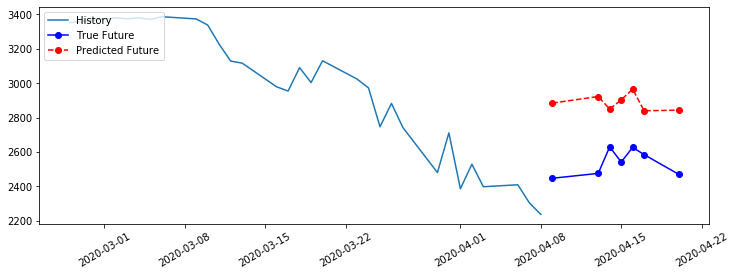

History date range: 2020-01-16 00:00:00, 2020-02-28 00:00:00
Future date range: 2020-03-02 00:00:00, 2020-03-10 00:00:00


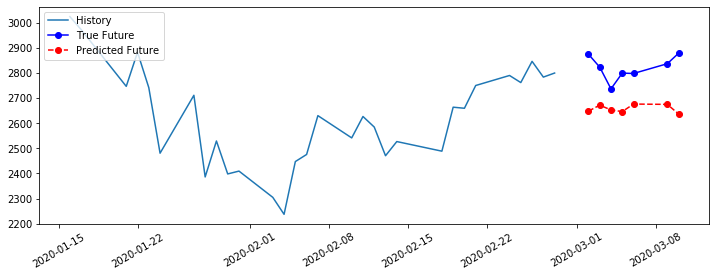

History date range: 2020-03-19 00:00:00, 2020-04-30 00:00:00
Future date range: 2020-05-01 00:00:00, 2020-05-11 00:00:00


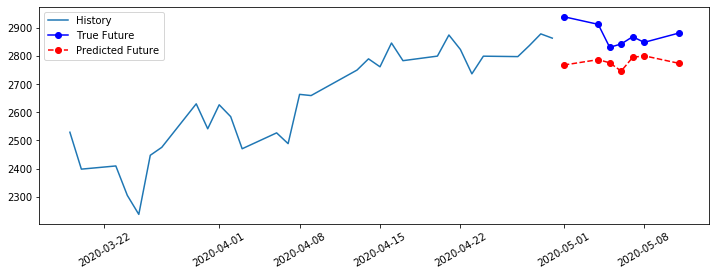

History date range: 2020-01-10 00:00:00, 2020-02-24 00:00:00
Future date range: 2020-02-25 00:00:00, 2020-03-04 00:00:00


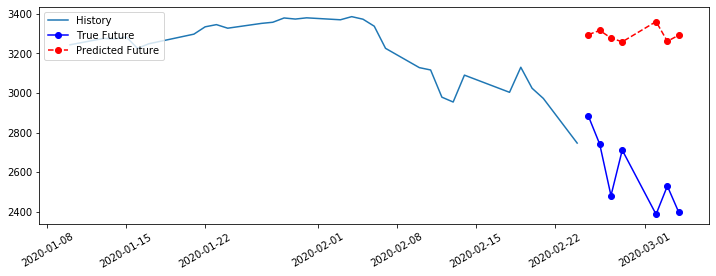

History date range: 2020-01-09 00:00:00, 2020-02-21 00:00:00
Future date range: 2020-02-24 00:00:00, 2020-03-03 00:00:00


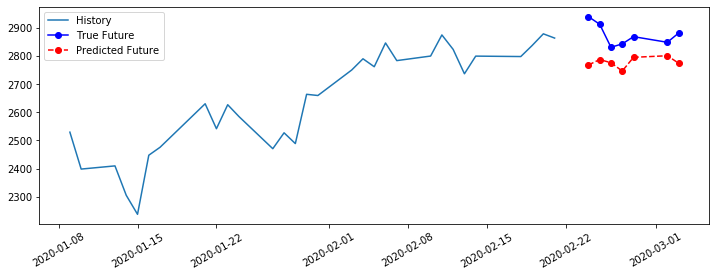

History date range: 2020-01-07 00:00:00, 2020-02-19 00:00:00
Future date range: 2020-02-20 00:00:00, 2020-02-28 00:00:00


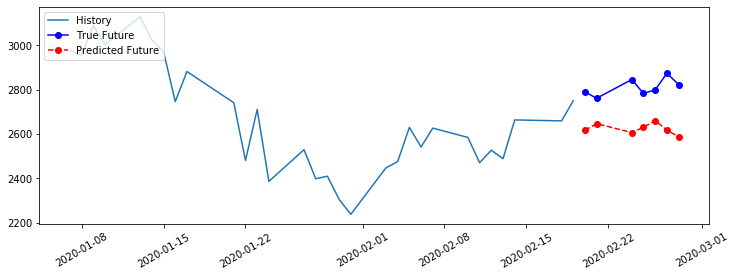

In [40]:
for xy, date in zip(test_data.take(6), test_dates.take(6)):
    
    x, y = xy
    x_dates, y_dates = date
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = best_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

In [41]:
best_model.save('models/keras_tuned_model.h5')

### 4.3. Predict future prices!
(code run 2020-06-19)

History date range: 2020-05-06 00:00:00, 2020-06-17 00:00:00
Future date range: 2020-06-19 00:00:00, 2020-06-29 00:00:00


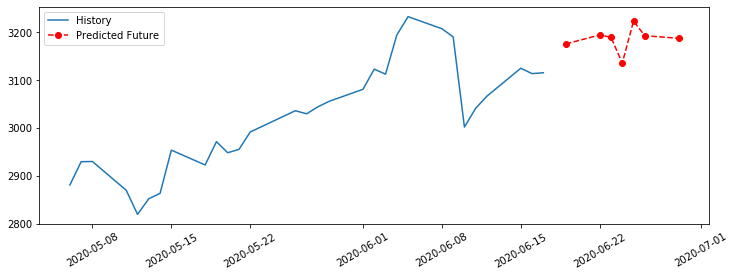

In [42]:
for x, date in zip(real_predict_data.take(1), real_predict_dates.take(1)):
    
    x_dates, y_dates = date
    history = x[0].numpy() [:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    prediction = best_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), prediction=prediction_rescaled)